In [52]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from pywaffle import Waffle
from wordcloud import WordCloud
import squarify
import plotly.express as px
import plotly.graph_objects as go
import warnings
# warnings.filterwarnings('ignore')

# Thiết lập style ggplot cho matplotlib
plt.style.use('ggplot')
sns.set_palette("husl")

# Cấu hình hiển thị
%matplotlib inline
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Thiết lập kích thước mặc định cho biểu đồ
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10


In [53]:
# Tải dữ liệu đã làm sạch
df = pd.read_csv("Amazon_SaleData_Cleaned.csv")

# Chuyển đổi OrderDate sang datetime
df["OrderDate"] = pd.to_datetime(df["OrderDate"])

# Tạo các biến phụ trợ cho phân tích
df["Year"] = df["OrderDate"].dt.year
df["Month"] = df["OrderDate"].dt.month
df["Quarter"] = df["OrderDate"].dt.quarter
df["YearMonth"] = df["OrderDate"].dt.to_period("M")
df["DayOfWeek"] = df["OrderDate"].dt.day_name()
df["MonthName"] = df["OrderDate"].dt.month_name()
df["DayOfMonth"] = df["OrderDate"].dt.day
holidays = pd.to_datetime(
    [
        # New Year
        "2020-01-01",
        "2021-01-01",
        "2022-01-01",
        "2023-01-01",
        "2024-01-01",
        # Christmas Eve & Christmas
        "2020-12-24",
        "2020-12-25",
        "2021-12-24",
        "2021-12-25",
        "2022-12-24",
        "2022-12-25",
        "2023-12-24",
        "2023-12-25",
        "2024-12-24",
        "2024-12-25",
        # Black Friday
        "2020-11-27",
        "2021-11-26",
        "2022-11-25",
        "2023-11-24",
        "2024-11-29",
        # Cyber Monday (Black Friday + 3 days)
        "2020-11-30",
        "2021-11-29",
        "2022-11-28",
        "2023-11-27",
        "2024-12-02",
    ]
)

# Tạo cột holiday flag
df["is_holiday"] = df["OrderDate"].dt.date.isin(holidays.date).astype(int)

# Tính toán các metrics bổ sung

print(f"Dataset shape: {df.shape}")
print(f"Thời gian: {df['OrderDate'].min()} đến {df['OrderDate'].max()}")
print(f"\nĐã tải dữ liệu và tạo các biến phụ trợ thành công!")
df.head(10)
df.columns

Dataset shape: (100000, 30)
Thời gian: 2020-01-01 00:00:00 đến 2024-12-29 00:00:00

Đã tải dữ liệu và tạo các biến phụ trợ thành công!


Index(['OrderID', 'OrderDate', 'CustomerID', 'CustomerName', 'ProductID',
       'ProductName', 'Category', 'Brand', 'Quantity', 'UnitPrice', 'Discount',
       'Tax', 'ShippingCost', 'TotalAmount', 'PaymentMethod', 'OrderStatus',
       'City', 'State', 'Country', 'SellerID', 'day_of_week', 'Revenue',
       'Year', 'Month', 'Quarter', 'YearMonth', 'DayOfWeek', 'MonthName',
       'DayOfMonth', 'is_holiday'],
      dtype='object')

PHÂN TÍCH TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF ĐỐI VỚI REVENUE

📋 Các cột số được phân tích: ['Revenue', 'Quantity', 'UnitPrice', 'Discount', 'Tax', 'ShippingCost', 'TotalAmount', 'is_holiday']

📊 TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF VỚI REVENUE:
Revenue         1.00
TotalAmount     0.72
Tax             0.57
UnitPrice       0.52
Quantity        0.43
ShippingCost    0.03
is_holiday     -0.00
Discount       -0.07
Name: Revenue, dtype: float64


📈 PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN VỚI REVENUE:
   TotalAmount: 0.7232 (Tích cực, Rất mạnh)
   Tax: 0.5721 (Tích cực, Mạnh)
   UnitPrice: 0.5201 (Tích cực, Mạnh)
   Quantity: 0.4316 (Tích cực, Trung bình)
   ShippingCost: 0.0279 (Tích cực, Rất yếu)
🎄 is_holiday: -0.0015 (Tiêu cực, Rất yếu)
   Discount: -0.0737 (Tiêu cực, Rất yếu)

🎄 PHÂN TÍCH ĐẶC BIỆT: ẢNH HƯỞNG CỦA NGÀY LỄ ĐẾN REVENUE

📊 Point-Biserial Correlation:
  - Correlation: -0.0015
  - P-value: 6.4010e-01
  - Significant: ❌ No

📈 So sánh Revenue:
  Ngày lễ:
    - Count: 1,433
    - Mean: $672.78
    -

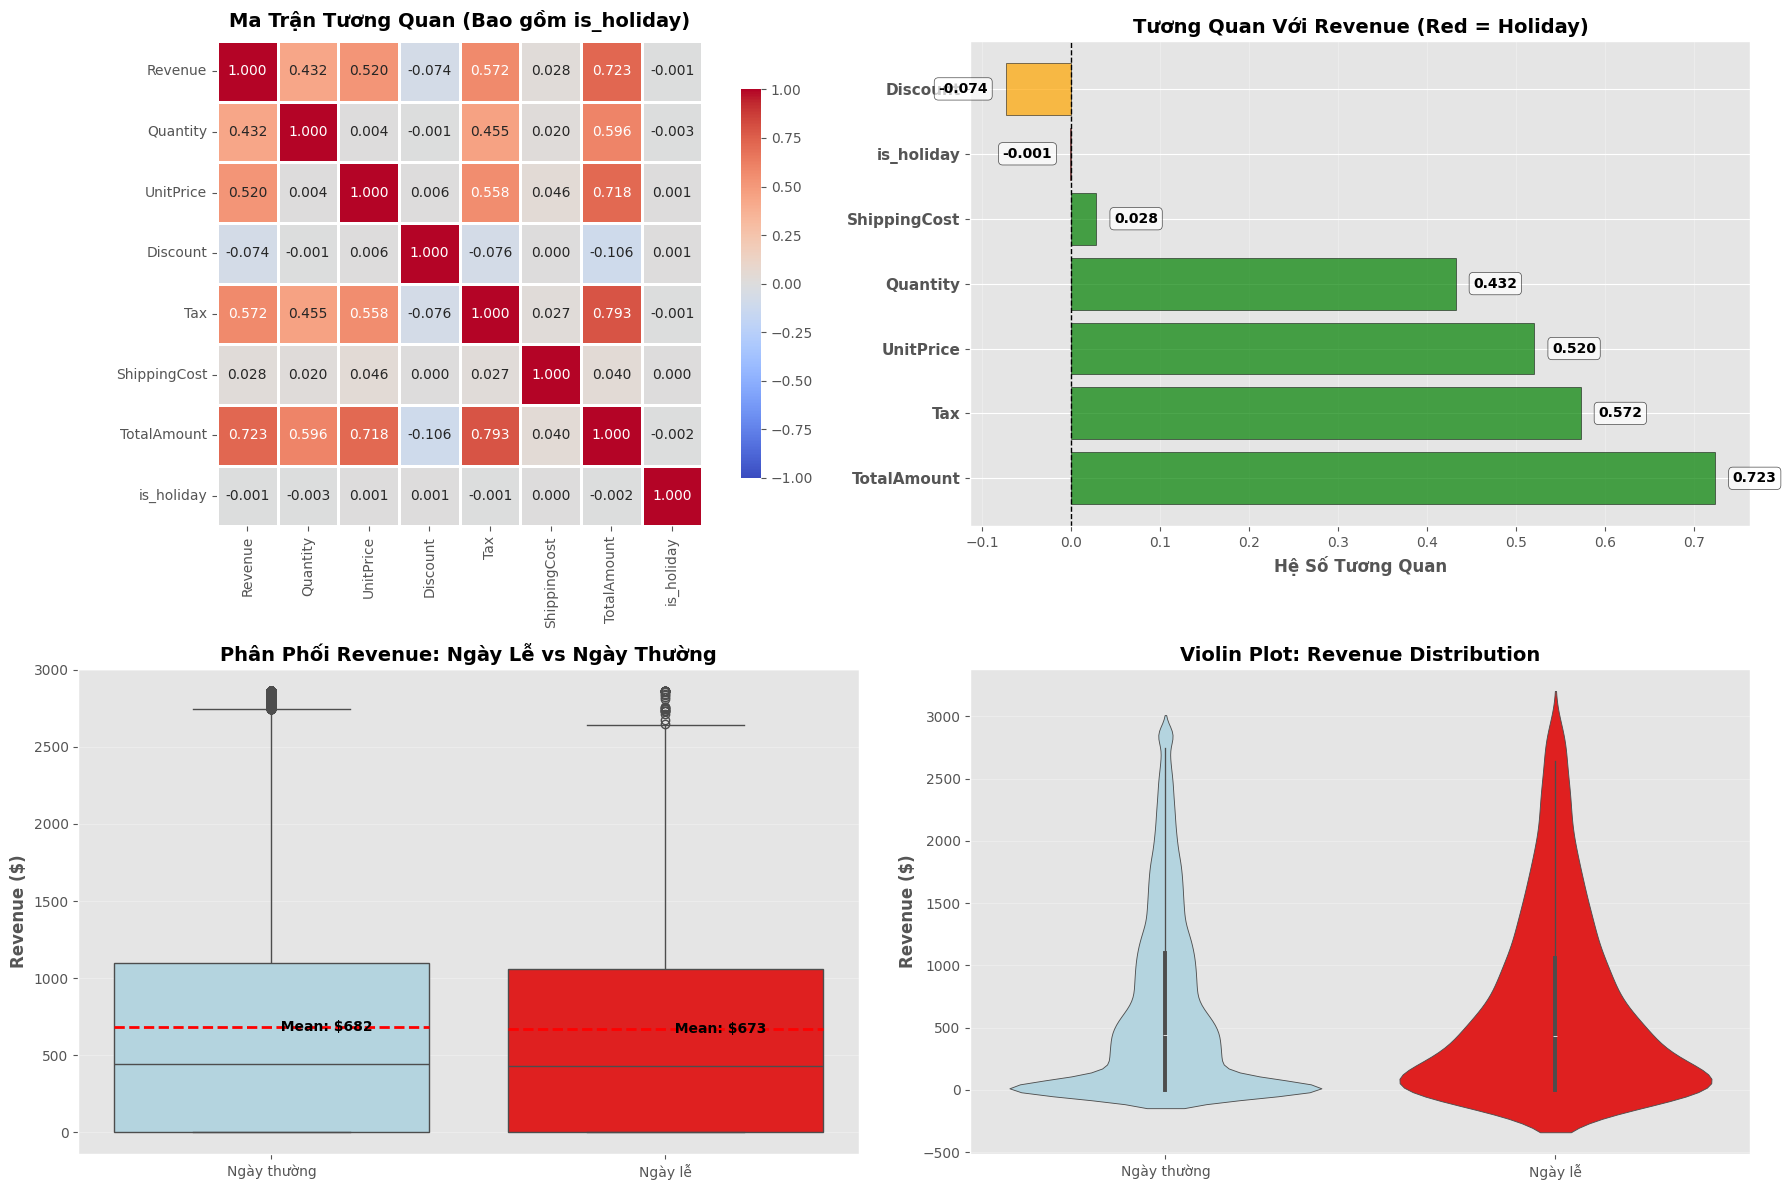


📊 PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH VỚI REVENUE:

Có 3 biến có tương quan mạnh với Revenue:

   ➤ TotalAmount (r = 0.7232):
    - Mean: 915.59
    - Median: 714.32
    - Std: 716.75
    - Range: [4.27, 2863.08]

   ➤ Tax (r = 0.5721):
    - Mean: 64.62
    - Median: 45.25
    - Std: 61.80
    - Range: [0.00, 216.27]

   ➤ UnitPrice (r = 0.5201):
    - Mean: 302.91
    - Median: 303.07
    - Std: 171.84
    - Range: [5.00, 599.99]

📊 ANOVA ANALYSIS: ẢNH HƯỞNG CỦA BIẾN CATEGORY ĐẾN REVENUE

📋 Kết quả ANOVA (sắp xếp theo p-value):
      feature   F_stat  p_value  n_categories is_significant
  OrderStatus 10329.78     0.00             5              ✅
        Brand     1.98     0.04            10              ✅
        State     1.12     0.33            13              ❌
     Category     1.09     0.36             6              ❌
    DayOfWeek     0.97     0.44             7              ❌
PaymentMethod     0.86     0.50             6              ❌
      Country     0.82   

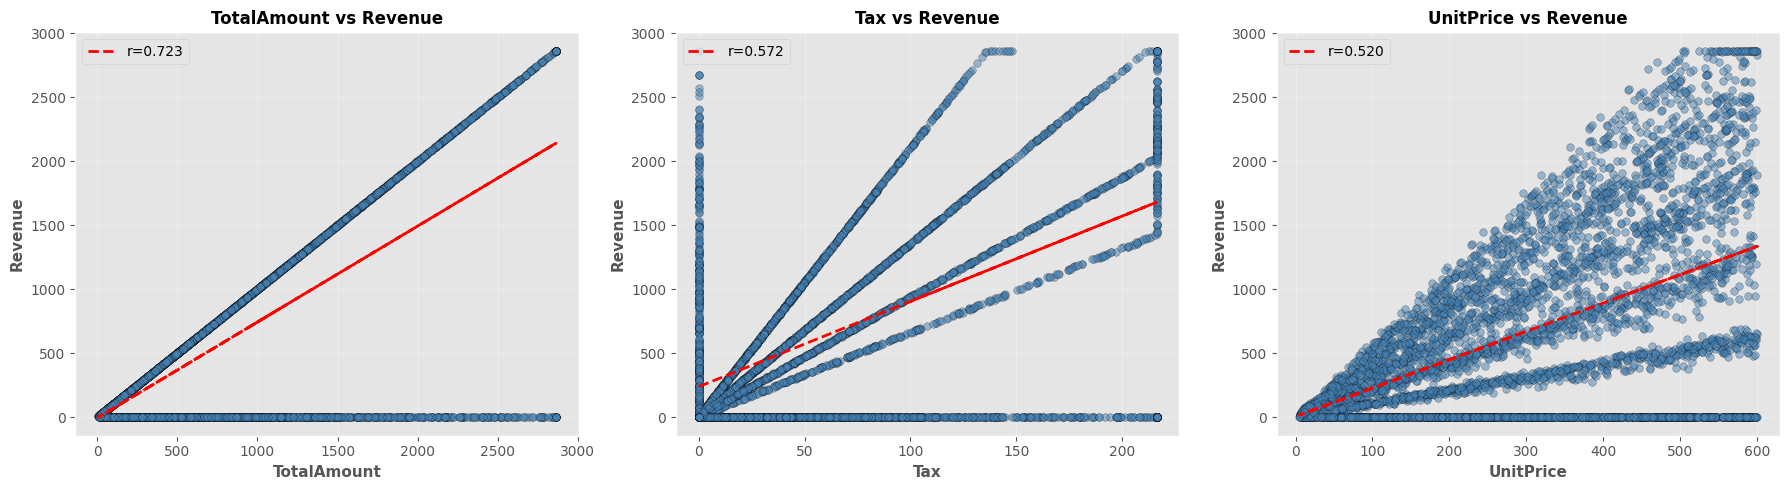


⚠️ CÁC CẶP BIẾN CÓ TƯƠNG QUAN CAO (|r| >= 0.7):
  • UnitPrice ↔ TotalAmount: r = 0.718
  • Tax ↔ TotalAmount: r = 0.793

💡 Lưu ý: Multicollinearity có thể ảnh hưởng đến mô hình regression.

📋 KẾT LUẬN TỔNG HỢP:

✅ Top 5 biến có tương quan DƯƠNG cao nhất với Revenue:
  1.   TotalAmount: r = 0.7232
  2.   Tax: r = 0.5721
  3.   UnitPrice: r = 0.5201
  4.   Quantity: r = 0.4316
  5.   ShippingCost: r = 0.0279

🎄 Phân tích đặc biệt - is_holiday:
  - Correlation: -0.0015
  - Point-biserial: -0.0015 (p=0.0000e+00)
  - Revenue tăng: -1.34% vào ngày lễ
  - Có ý nghĩa thống kê: ✅ Yes

❌ Biến có tương quan ÂM:
  1. is_holiday: r = -0.0015
  2. Discount: r = -0.0737

💡 KHUYẾN NGHỊ:
- is_holiday có thể là feature hữu ích cho mô hình forecasting
- Nên kết hợp với các lag features và seasonal patterns
- Xem xét interaction features: is_holiday × quarter, is_holiday × month


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

print("=" * 80)
print("PHÂN TÍCH TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF ĐỐI VỚI REVENUE")
print("=" * 80)

# =============================================================================
# 1️⃣ CHỌN CÁC BIẾN SỐ TỪ DF ĐỂ PHÂN TÍCH TƯƠNG QUAN
# =============================================================================
# Tính Revenue nếu chưa có
if "Revenue" not in df.columns:
    df["Revenue"] = np.where(df["OrderStatus"] == "Delivered", df["TotalAmount"], 0)

numeric_cols_df = [
    "Revenue",
    "Quantity",
    "UnitPrice",
    "Discount",
    "Tax",
    "ShippingCost",
    "TotalAmount",
    "is_holiday",  # ✅ Thêm is_holiday vào danh sách
]

# Lọc ra các cột số có trong df
available_cols = [col for col in numeric_cols_df if col in df.columns]
print(f"\n📋 Các cột số được phân tích: {available_cols}")

# Tính ma trận tương quan
correlation_matrix_df = df[available_cols].corr()

# =============================================================================
# 2️⃣ TRÍCH XUẤT TƯƠNG QUAN VỚI REVENUE
# =============================================================================
revenue_corr_df = correlation_matrix_df["Revenue"].sort_values(ascending=False)
print("\n📊 TƯƠNG QUAN CỦA CÁC BIẾN TRONG DF VỚI REVENUE:")
print(revenue_corr_df)
print("\n" + "=" * 80)


# =============================================================================
# 3️⃣ PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN
# =============================================================================
def classify_correlation(corr_value):
    abs_corr = abs(corr_value)
    if abs_corr >= 0.7:
        return "Rất mạnh"
    elif abs_corr >= 0.5:
        return "Mạnh"
    elif abs_corr >= 0.3:
        return "Trung bình"
    elif abs_corr >= 0.1:
        return "Yếu"
    else:
        return "Rất yếu"


print("\n📈 PHÂN LOẠI MỨC ĐỘ TƯƠNG QUAN VỚI REVENUE:")
for var, corr in revenue_corr_df.items():
    if var != "Revenue":
        strength = classify_correlation(corr)
        direction = "Tích cực" if corr > 0 else "Tiêu cực"
        emoji = "🎄" if var == "is_holiday" else "  "
        print(f"{emoji} {var}: {corr:.4f} ({direction}, {strength})")

# =============================================================================
# 4️⃣ PHÂN TÍCH ĐẶC BIỆT CHO is_holiday
# =============================================================================
print("\n" + "=" * 80)
print("🎄 PHÂN TÍCH ĐẶC BIỆT: ẢNH HƯỞNG CỦA NGÀY LỄ ĐẾN REVENUE")
print("=" * 80)

# Point-biserial correlation (cho binary variable)
from scipy.stats import pointbiserialr

point_biserial_corr, p_value = pointbiserialr(df["is_holiday"], df["Revenue"])
print(f"\n📊 Point-Biserial Correlation:")
print(f"  - Correlation: {point_biserial_corr:.4f}")
print(f"  - P-value: {p_value:.4e}")
print(f"  - Significant: {'✅ Yes' if p_value < 0.05 else '❌ No'}")

# So sánh Revenue giữa ngày lễ và ngày thường
holiday_revenue = df[df["is_holiday"] == 1]["Revenue"]
normal_revenue = df[df["is_holiday"] == 0]["Revenue"]

print(f"\n📈 So sánh Revenue:")
print(f"  Ngày lễ:")
print(f"    - Count: {len(holiday_revenue):,}")
print(f"    - Mean: ${holiday_revenue.mean():,.2f}")
print(f"    - Median: ${holiday_revenue.median():,.2f}")
print(f"    - Total: ${holiday_revenue.sum():,.2f}")

print(f"\n  Ngày thường:")
print(f"    - Count: {len(normal_revenue):,}")
print(f"    - Mean: ${normal_revenue.mean():,.2f}")
print(f"    - Median: ${normal_revenue.median():,.2f}")
print(f"    - Total: ${normal_revenue.sum():,.2f}")

revenue_increase = ((holiday_revenue.mean() / normal_revenue.mean()) - 1) * 100
print(f"\n💡 Revenue tăng trung bình: {revenue_increase:+.2f}% vào ngày lễ")

# T-test để kiểm tra sự khác biệt
t_stat, t_pvalue = stats.ttest_ind(holiday_revenue, normal_revenue)
print(f"\n🔬 Independent T-test:")
print(f"  - T-statistic: {t_stat:.4f}")
print(f"  - P-value: {t_pvalue:.4e}")
print(
    f"  - Kết luận: {'✅ Có sự khác biệt có ý nghĩa' if t_pvalue < 0.05 else '❌ Không có sự khác biệt'}"
)

# =============================================================================
# 5️⃣ VISUALIZATION - THÊM is_holiday
# =============================================================================
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 5.1. Heatmap đầy đủ
sns.heatmap(
    correlation_matrix_df,
    annot=True,
    fmt=".3f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8},
    ax=axes[0, 0],
    vmin=-1,
    vmax=1,
)
axes[0, 0].set_title(
    "Ma Trận Tương Quan (Bao gồm is_holiday)",
    fontweight="bold",
    fontsize=14,
    pad=10,
)

# 5.2. Bar chart: Tương quan với Revenue
revenue_corr_filtered_df = revenue_corr_df.drop("Revenue")
colors = [
    "red" if "holiday" in str(idx).lower() else ("green" if x > 0 else "orange")
    for idx, x in zip(revenue_corr_filtered_df.index, revenue_corr_filtered_df.values)
]

axes[0, 1].barh(
    range(len(revenue_corr_filtered_df)),
    revenue_corr_filtered_df.values,
    color=colors,
    alpha=0.7,
    edgecolor="black",
)
axes[0, 1].set_yticks(range(len(revenue_corr_filtered_df)))
axes[0, 1].set_yticklabels(
    revenue_corr_filtered_df.index, fontweight="bold", fontsize=11
)
axes[0, 1].axvline(x=0, color="black", linestyle="--", linewidth=1)
axes[0, 1].set_xlabel("Hệ Số Tương Quan", fontweight="bold", fontsize=12)
axes[0, 1].set_title(
    "Tương Quan Với Revenue (Red = Holiday)",
    fontweight="bold",
    fontsize=14,
)
axes[0, 1].grid(True, alpha=0.3, axis="x")

for i, (var, corr) in enumerate(revenue_corr_filtered_df.items()):
    x_pos = corr + (0.02 if corr > 0 else -0.02)
    ha = "left" if corr > 0 else "right"
    axes[0, 1].text(
        x_pos,
        i,
        f"{corr:.3f}",
        ha=ha,
        va="center",
        fontweight="bold",
        fontsize=10,
        bbox=dict(facecolor="white", edgecolor="black", boxstyle="round", alpha=0.7),
    )

# 5.3. Boxplot: Revenue theo is_holiday
df_plot = df[["is_holiday", "Revenue"]].copy()
df_plot["Holiday"] = df_plot["is_holiday"].map({0: "Ngày thường", 1: "Ngày lễ"})

sns.boxplot(
    data=df_plot, x="Holiday", y="Revenue", ax=axes[1, 0], palette=["lightblue", "red"]
)
axes[1, 0].set_title(
    "Phân Phối Revenue: Ngày Lễ vs Ngày Thường", fontweight="bold", fontsize=14
)
axes[1, 0].set_ylabel("Revenue ($)", fontweight="bold")
axes[1, 0].set_xlabel("")
axes[1, 0].grid(True, alpha=0.3, axis="y")

# Thêm mean lines
for i, cat in enumerate(["Ngày thường", "Ngày lễ"]):
    mean_val = df_plot[df_plot["Holiday"] == cat]["Revenue"].mean()
    axes[1, 0].hlines(
        mean_val, i - 0.4, i + 0.4, colors="red", linestyles="--", linewidth=2
    )
    axes[1, 0].text(
        i,
        mean_val,
        f"  Mean: ${mean_val:,.0f}",
        fontweight="bold",
        fontsize=10,
        va="center",
    )

# 5.4. Violin plot: Revenue theo is_holiday
sns.violinplot(
    data=df_plot, x="Holiday", y="Revenue", ax=axes[1, 1], palette=["lightblue", "red"]
)
axes[1, 1].set_title(
    "Violin Plot: Revenue Distribution", fontweight="bold", fontsize=14
)
axes[1, 1].set_ylabel("Revenue ($)", fontweight="bold")
axes[1, 1].set_xlabel("")
axes[1, 1].grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# =============================================================================
# 6️⃣ PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH
# =============================================================================
print("\n" + "=" * 80)
print("📊 PHÂN TÍCH CHI TIẾT CÁC BIẾN CÓ TƯƠNG QUAN MẠNH VỚI REVENUE:")
print("=" * 80)

strong_corr_vars_df = revenue_corr_filtered_df[abs(revenue_corr_filtered_df) >= 0.5]

if len(strong_corr_vars_df) > 0:
    print(f"\nCó {len(strong_corr_vars_df)} biến có tương quan mạnh với Revenue:")
    for var, corr in strong_corr_vars_df.items():
        emoji = "🎄" if var == "is_holiday" else "  "
        print(f"\n{emoji} ➤ {var} (r = {corr:.4f}):")
        if var == "is_holiday":
            print(f"    - Binary variable (0/1)")
            print(f"    - Holiday days: {df[var].sum()}")
            print(f"    - Point-biserial r: {point_biserial_corr:.4f}")
        else:
            print(f"    - Mean: {df[var].mean():.2f}")
            print(f"    - Median: {df[var].median():.2f}")
            print(f"    - Std: {df[var].std():.2f}")
            print(f"    - Range: [{df[var].min():.2f}, {df[var].max():.2f}]")
else:
    print("Không có biến nào có tương quan mạnh (|corr| >= 0.5) với Revenue.")

# =============================================================================
# 7️⃣ ANOVA ANALYSIS CHO BIẾN CATEGORY (BAO GỒM is_holiday)
# =============================================================================
print("\n" + "=" * 80)
print("📊 ANOVA ANALYSIS: ẢNH HƯỞNG CỦA BIẾN CATEGORY ĐẾN REVENUE")
print("=" * 80)

cat_cols = [
    "PaymentMethod",
    "Category",
    "Brand",
    "City",
    "State",
    "Country",
    "OrderStatus",
    "DayOfWeek",
    "DayOfMonth",
    "Month",
    "is_holiday",  # ✅ Thêm is_holiday vào ANOVA
]

anova_rows = []
for c in cat_cols:
    if c not in df.columns:
        continue

    tmp = df[[c, "Revenue"]].dropna()
    if tmp[c].nunique() < 2:
        continue

    try:
        m = smf.ols(f"Revenue ~ C({c})", data=tmp).fit()
        a = sm.stats.anova_lm(m, typ=2)
        p = a.loc[f"C({c})", "PR(>F)"]
        f = a.loc[f"C({c})", "F"]

        anova_rows.append(
            {
                "feature": c,
                "F_stat": f,
                "p_value": p,
                "n_categories": tmp[c].nunique(),
                "is_significant": "✅" if p < 0.05 else "❌",
            }
        )
    except:
        print(f"⚠️ Không thể chạy ANOVA cho {c}")

anova_df = pd.DataFrame(anova_rows).sort_values("p_value")

print("\n📋 Kết quả ANOVA (sắp xếp theo p-value):")
print(anova_df.to_string(index=False))

print("\n" + "=" * 80)
print("🎄 CHI TIẾT is_holiday TRONG ANOVA:")
print("=" * 80)

if "is_holiday" in anova_df["feature"].values:
    holiday_row = anova_df[anova_df["feature"] == "is_holiday"].iloc[0]
    print(f"  - F-statistic: {holiday_row['F_stat']:.4f}")
    print(f"  - P-value: {holiday_row['p_value']:.4e}")
    print(f"  - Significant: {holiday_row['is_significant']}")
    print(
        f"  - Ranking: #{anova_df[anova_df['feature'] == 'is_holiday'].index[0] + 1}/{len(anova_df)}"
    )

    if holiday_row["p_value"] < 0.05:
        print("\n  💡 Kết luận: Ngày lễ có ảnh hưởng có ý nghĩa thống kê đến Revenue!")
    else:
        print(
            "\n  ⚠️ Kết luận: Ngày lễ KHÔNG có ảnh hưởng có ý nghĩa thống kê đến Revenue"
        )

# =============================================================================
# 8️⃣ SCATTER PLOTS CHO CÁC BIẾN CÓ TƯƠNG QUAN CAO
# =============================================================================
strong_vars_df = [
    var for var in strong_corr_vars_df.index if var != "Revenue" and var != "is_holiday"
]

if len(strong_vars_df) > 0:
    df_sample = df.sample(n=min(5000, len(df)), random_state=42)

    n_vars = len(strong_vars_df)
    n_cols = min(3, n_vars)
    n_rows = (n_vars + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

    if n_vars == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_vars > 1 else [axes]

    for idx, var in enumerate(strong_vars_df):
        axes[idx].scatter(
            df_sample[var],
            df_sample["Revenue"],
            alpha=0.5,
            s=30,
            color="steelblue",
            edgecolors="black",
            linewidth=0.3,
        )

        slope, intercept, r_value, p_value, std_err = stats.linregress(
            df_sample[var], df_sample["Revenue"]
        )
        line = slope * df_sample[var] + intercept
        axes[idx].plot(
            df_sample[var],
            line,
            "r--",
            linewidth=2,
            label=f"r={revenue_corr_filtered_df[var]:.3f}",
        )

        axes[idx].set_xlabel(var, fontweight="bold", fontsize=11)
        axes[idx].set_ylabel("Revenue", fontweight="bold", fontsize=11)
        axes[idx].set_title(f"{var} vs Revenue", fontweight="bold", fontsize=12)
        axes[idx].legend(loc="best", fontsize=10)
        axes[idx].grid(True, alpha=0.3)

    for idx in range(len(strong_vars_df), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()

# =============================================================================
# 9️⃣ MULTICOLLINEARITY CHECK
# =============================================================================
print("\n" + "=" * 80)
print("⚠️ CÁC CẶP BIẾN CÓ TƯƠNG QUAN CAO (|r| >= 0.7):")
print("=" * 80)

high_corr_pairs = []
for i in range(len(correlation_matrix_df.columns)):
    for j in range(i + 1, len(correlation_matrix_df.columns)):
        var1 = correlation_matrix_df.columns[i]
        var2 = correlation_matrix_df.columns[j]
        corr_val = correlation_matrix_df.iloc[i, j]

        if abs(corr_val) >= 0.7 and var1 != "Revenue" and var2 != "Revenue":
            high_corr_pairs.append((var1, var2, corr_val))

if high_corr_pairs:
    for var1, var2, corr in high_corr_pairs:
        print(f"  • {var1} ↔ {var2}: r = {corr:.3f}")
    print("\n💡 Lưu ý: Multicollinearity có thể ảnh hưởng đến mô hình regression.")
else:
    print("  ✅ Không có cặp biến nào có tương quan quá cao (tốt cho modeling).")

# =============================================================================
# 🔟 KẾT LUẬN TỔNG HỢP
# =============================================================================
print("\n" + "=" * 80)
print("📋 KẾT LUẬN TỔNG HỢP:")
print("=" * 80)

print(f"\n✅ Top 5 biến có tương quan DƯƠNG cao nhất với Revenue:")
for i, (var, corr) in enumerate(revenue_corr_filtered_df.head(5).items(), 1):
    emoji = "🎄" if var == "is_holiday" else "  "
    print(f"  {i}. {emoji}{var}: r = {corr:.4f}")

print(f"\n🎄 Phân tích đặc biệt - is_holiday:")
print(f"  - Correlation: {revenue_corr_df['is_holiday']:.4f}")
print(f"  - Point-biserial: {point_biserial_corr:.4f} (p={p_value:.4e})")
print(f"  - Revenue tăng: {revenue_increase:+.2f}% vào ngày lễ")
print(f"  - Có ý nghĩa thống kê: {'✅ Yes' if p_value < 0.05 else '❌ No'}")

negative_corrs = revenue_corr_filtered_df[revenue_corr_filtered_df < 0]
if len(negative_corrs) > 0:
    print(f"\n❌ Biến có tương quan ÂM:")
    for i, (var, corr) in enumerate(negative_corrs.items(), 1):
        print(f"  {i}. {var}: r = {corr:.4f}")
else:
    print("\n  ✓ Không có biến nào có tương quan âm với Revenue")

print("\n" + "=" * 80)
print("💡 KHUYẾN NGHỊ:")
print("=" * 80)
print("- is_holiday có thể là feature hữu ích cho mô hình forecasting")
print("- Nên kết hợp với các lag features và seasonal patterns")
print("- Xem xét interaction features: is_holiday × quarter, is_holiday × month")
print("=" * 80)

In [55]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("=" * 80)
print("📊 TẠO WEEKLY DATA HOÀN CHỈNH (NUMERIC + CATEGORICAL ONE-HOT ENCODED)")
print("=" * 80)

# =============================================================================
# 1️⃣ ONE-HOT ENCODE CATEGORICAL FEATURES TRƯỚC KHI AGGREGATE
# =============================================================================
print("\n1️⃣ One-hot encoding categorical features")
print("-" * 80)

# Chọn categorical columns để encode
categorical_cols = ["Category", "PaymentMethod", "Country"]

# One-hot encode
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

print(f"✅ Shape sau encoding: {df_encoded.shape}")
print(f"   Từ {df.shape[1]} cột → {df_encoded.shape[1]} cột")

# Tạo RealizedRevenue và week
if "RealizedRevenue" not in df_encoded.columns:
    df_encoded["RealizedRevenue"] = np.where(
        df_encoded["OrderStatus"] == "Delivered", df_encoded["TotalAmount"], 0
    )

df_encoded["week"] = df_encoded["OrderDate"].dt.to_period("W")

# =============================================================================
# 2️⃣ LẤY DANH SÁCH DUMMY COLUMNS
# =============================================================================
dummy_cols = [
    col
    for col in df_encoded.columns
    if any(col.startswith(prefix + "_") for prefix in categorical_cols)
]

print(f"\n📋 Dummy variables created ({len(dummy_cols)} total):")
for prefix in categorical_cols:
    prefix_cols = [c for c in dummy_cols if c.startswith(prefix + "_")]
    print(f"   • {prefix}: {len(prefix_cols)} dummies")

# =============================================================================
# 3️⃣ AGGREGATE THEO WEEK (BAO GỒM NUMERIC VÀ DUMMY FEATURES)
# =============================================================================
print("\n\n2️⃣ Aggregating by week")
print("-" * 80)

# Aggregation cho numeric features
agg_dict = {
    "RealizedRevenue": "sum",
    "OrderID": "nunique",
    "Quantity": "sum",
    "Discount": "mean",
    "OrderStatus": lambda x: (x == "Delivered").sum() / len(x),
}

# Thêm dummy columns (sum = số lượng orders của category đó)
for col in dummy_cols:
    agg_dict[col] = "sum"

# Aggregate
weekly_full = df_encoded.groupby("week").agg(agg_dict).reset_index()

# Rename numeric columns
weekly_full.rename(
    columns={
        "RealizedRevenue": "Revenue",
        "OrderID": "Orders",
        "OrderStatus": "DeliveryRate",
        "Discount": "AvgDiscount",
    },
    inplace=True,
)

print(f"✅ Shape sau aggregation: {weekly_full.shape}")

# =============================================================================
# 4️⃣ THÊM HOLIDAY FEATURES
# =============================================================================
print("\n3️⃣ Adding holiday features")
print("-" * 80)

# Tính HolidayDays
holiday_days = (
    df_encoded[df_encoded["is_holiday"] == 1]
    .groupby("week")["OrderDate"]
    .apply(lambda x: x.dt.date.nunique())
    .reset_index()
    .rename(columns={"OrderDate": "HolidayDays"})
)

# Tính HolidayRevenue
holiday_revenue = (
    df_encoded[df_encoded["is_holiday"] == 1]
    .groupby("week")["RealizedRevenue"]
    .sum()
    .reset_index()
    .rename(columns={"RealizedRevenue": "HolidayRevenue"})
)

# Merge holiday features
weekly_full = weekly_full.merge(holiday_days, on="week", how="left")
weekly_full = weekly_full.merge(holiday_revenue, on="week", how="left")

# Fill NaN và tạo has_holiday flag
weekly_full["HolidayDays"] = weekly_full["HolidayDays"].fillna(0).astype(int)
weekly_full["HolidayRevenue"] = weekly_full["HolidayRevenue"].fillna(0)
weekly_full["has_holiday"] = (weekly_full["HolidayDays"] > 0).astype(int)

print(f"✅ Final shape: {weekly_full.shape}")
print(f"   - Weeks: {len(weekly_full)}")
print(f"   - Features: {weekly_full.shape[1] - 2}  (exclude 'week' and 'Revenue')")

# =============================================================================
# 5️⃣ PHÂN LOẠI FEATURES
# =============================================================================
print("\n" + "=" * 80)
print("📊 TỔNG HỢP FEATURES TRONG WEEKLY_FULL")
print("=" * 80)

# Numeric features
numeric_features = [
    "Orders",
    "Quantity",
    "AvgDiscount",
    "DeliveryRate",
    "HolidayDays",
    "HolidayRevenue",
    "has_holiday",
]

# Dummy features (by category)
category_dummies = [c for c in dummy_cols if c.startswith("Category_")]
payment_dummies = [c for c in dummy_cols if c.startswith("PaymentMethod_")]
country_dummies = [c for c in dummy_cols if c.startswith("Country_")]

print(f"\n✅ NUMERIC FEATURES ({len(numeric_features)}):")
for feat in numeric_features:
    emoji = "🎄" if "holiday" in feat.lower() else "  "
    print(f"{emoji} • {feat}")

print(f"\n✅ CATEGORY DUMMIES ({len(category_dummies)}):")
for feat in category_dummies[:5]:
    print(f"  • {feat}")
print(f"  ... (total {len(category_dummies)} categories)")

print(f"\n✅ PAYMENT METHOD DUMMIES ({len(payment_dummies)}):")
for feat in payment_dummies:
    print(f"  • {feat}")

print(f"\n✅ COUNTRY DUMMIES ({len(country_dummies)}):")
for feat in country_dummies:
    print(f"  • {feat}")

# =============================================================================
# 6️⃣ KIỂM TRA DỮ LIỆU
# =============================================================================
print("\n" + "=" * 80)
print("📋 KIỂM TRA DỮ LIỆU WEEKLY_FULL")
print("=" * 80)

print(f"\n📊 Shape: {weekly_full.shape}")
print(f"📊 Columns: {weekly_full.columns.tolist()[:10]}...")
print(f"\n📊 Sample data:")
print(weekly_full.head(3))

print(f"\n📊 Missing values:")
missing = weekly_full.isnull().sum()
if missing.sum() == 0:
    print("  ✅ Không có missing values!")
else:
    print(missing[missing > 0])

print(f"\n📊 Data types:")
print(weekly_full.dtypes.value_counts())

# =============================================================================
# 7️⃣ LƯU KẾT QUẢ
# =============================================================================
print("\n" + "=" * 80)
print("✅ KẾT QUẢ")
print("=" * 80)

# All features (exclude week and Revenue)
all_features = [col for col in weekly_full.columns if col not in ["week", "Revenue"]]

print(f"\n🎯 WEEKLY_FULL DATASET:")
print(f"   - Total rows: {len(weekly_full)}")
print(f"   - Total features: {len(all_features)}")
print(f"   - Numeric: {len(numeric_features)}")
print(f"   - Categorical (one-hot): {len(dummy_cols)}")

print(f"\n📦 Ready for modeling:")
print(f"   X = weekly_full[{len(all_features)} features]")
print(f"   y = weekly_full['Revenue']")

print("\n💡 NEXT STEPS:")
print("   1. Train Gradient Boosting với ALL features")
print("   2. Không cần lo về VIF (tree-based models handle multicollinearity)")
print("   3. Analyze feature importance")

print("\n" + "=" * 80)

# Display summary
weekly_full.head(10)

📊 TẠO WEEKLY DATA HOÀN CHỈNH (NUMERIC + CATEGORICAL ONE-HOT ENCODED)

1️⃣ One-hot encoding categorical features
--------------------------------------------------------------------------------
✅ Shape sau encoding: (100000, 44)
   Từ 30 cột → 44 cột

📋 Dummy variables created (17 total):
   • Category: 6 dummies
   • PaymentMethod: 6 dummies
   • Country: 5 dummies


2️⃣ Aggregating by week
--------------------------------------------------------------------------------
✅ Shape sau aggregation: (261, 23)

3️⃣ Adding holiday features
--------------------------------------------------------------------------------
✅ Final shape: (261, 26)
   - Weeks: 261
   - Features: 24  (exclude 'week' and 'Revenue')

📊 TỔNG HỢP FEATURES TRONG WEEKLY_FULL

✅ NUMERIC FEATURES (7):
   • Orders
   • Quantity
   • AvgDiscount
   • DeliveryRate
🎄 • HolidayDays
🎄 • HolidayRevenue
🎄 • has_holiday

✅ CATEGORY DUMMIES (6):
  • Category_Books
  • Category_Clothing
  • Category_Electronics
  • Category_Home & Ki

,week,Revenue,Orders,Quantity,AvgDiscount,DeliveryRate,Category_Books,Category_Clothing,Category_Electronics,Category_Home & Kitchen,Category_Sports & Outdoors,Category_Toys & Games,PaymentMethod_Amazon Pay,PaymentMethod_Cash On Delivery,PaymentMethod_Credit Card,PaymentMethod_Debit Card,PaymentMethod_Net Banking,PaymentMethod_Upi,Country_Australia,Country_Canada,Country_India,Country_United Kingdom,Country_United States,HolidayDays,HolidayRevenue,has_holiday
0,2019-12-30/2020-01-05,171833.31,262,780,0.08,0.74,47,44,30,37,51,53,41,12,96,45,24,44,7,15,41,9,190,1,44183.82,1
1,2020-01-06/2020-01-12,286423.78,386,1149,0.07,0.81,66,65,56,72,63,64,59,19,124,81,41,62,15,26,61,26,258,0,0.00,0
2,2020-01-13/2020-01-19,291221.55,410,1230,0.06,0.75,71,60,73,69,74,63,59,12,140,86,37,76,19,20,48,16,307,0,0.00,0
3,2020-01-20/2020-01-26,252467.77,377,1155,0.07,0.72,54,62,78,57,72,54,65,15,130,74,34,59,17,19,61,22,258,0,0.00,0
4,2020-01-27/2020-02-02,281012.07,387,1169,0.07,0.77,66,67,74,59,57,64,63,23,148,69,33,51,14,26,49,18,280,0,0.00,0
5,2020-02-03/2020-02-09,238748.61,358,1061,0.07,0.75,52,67,46,70,56,67,37,12,133,78,43,55,11,21,57,17,252,0,0.00,0
6,2020-02-10/2020-02-16,267896.85,365,1070,0.07,0.78,49,60,63,57,70,66,46,23,138,70,30,58,13,17,58,31,246,0,0.00,0
7,2020-02-17/2020-02-23,265112.71,374,1102,0.07,0.78,75,61,59,71,50,58,58,19,109,75,43,70,14,21,65,20,254,0,0.00,0
8,2020-02-24/2020-03-01,236156.17,346,974,0.06,0.76,60,65,51,54,62,54,56,15,113,78,37,47,11,18,43,15,259,0,0.00,0
9,2020-03-02/2020-03-08,257471.63,362,1102,0.07,0.74,59,69,69,50,60,55,54,16,118,74,30,70,14,24,49,15,260,0,0.00,0


🔬 KIỂM TRA ASSUMPTIONS CHO LINEAR REGRESSION (WEEKLY_FULL)

1️⃣ Chuẩn bị dữ liệu
--------------------------------------------------------------------------------
✅ Dataset prepared:
   - X shape: (261, 24)
   - y shape: (261,)
   - Features: 24

2️⃣ Training Linear Regression
--------------------------------------------------------------------------------
✅ Model trained:
   - R²: 0.7794
   - Adj R²: 0.7600
   - F-statistic: 40.22
   - Prob (F-statistic): 2.4738e-66

📊 ASSUMPTION 1: LINEARITY

📋 Top 10 features with highest non-linearity:
                  Feature  Pearson_r  Spearman_r  Difference Is_Linear
     Category_Electronics       0.43        0.37        0.06         ✅
            Country_India       0.23        0.18        0.05         ✅
 PaymentMethod_Debit Card       0.36        0.32        0.04         ✅
 PaymentMethod_Amazon Pay       0.23        0.19        0.04         ✅
                   Orders       0.72        0.69        0.03         ✅
        Country_Australia    

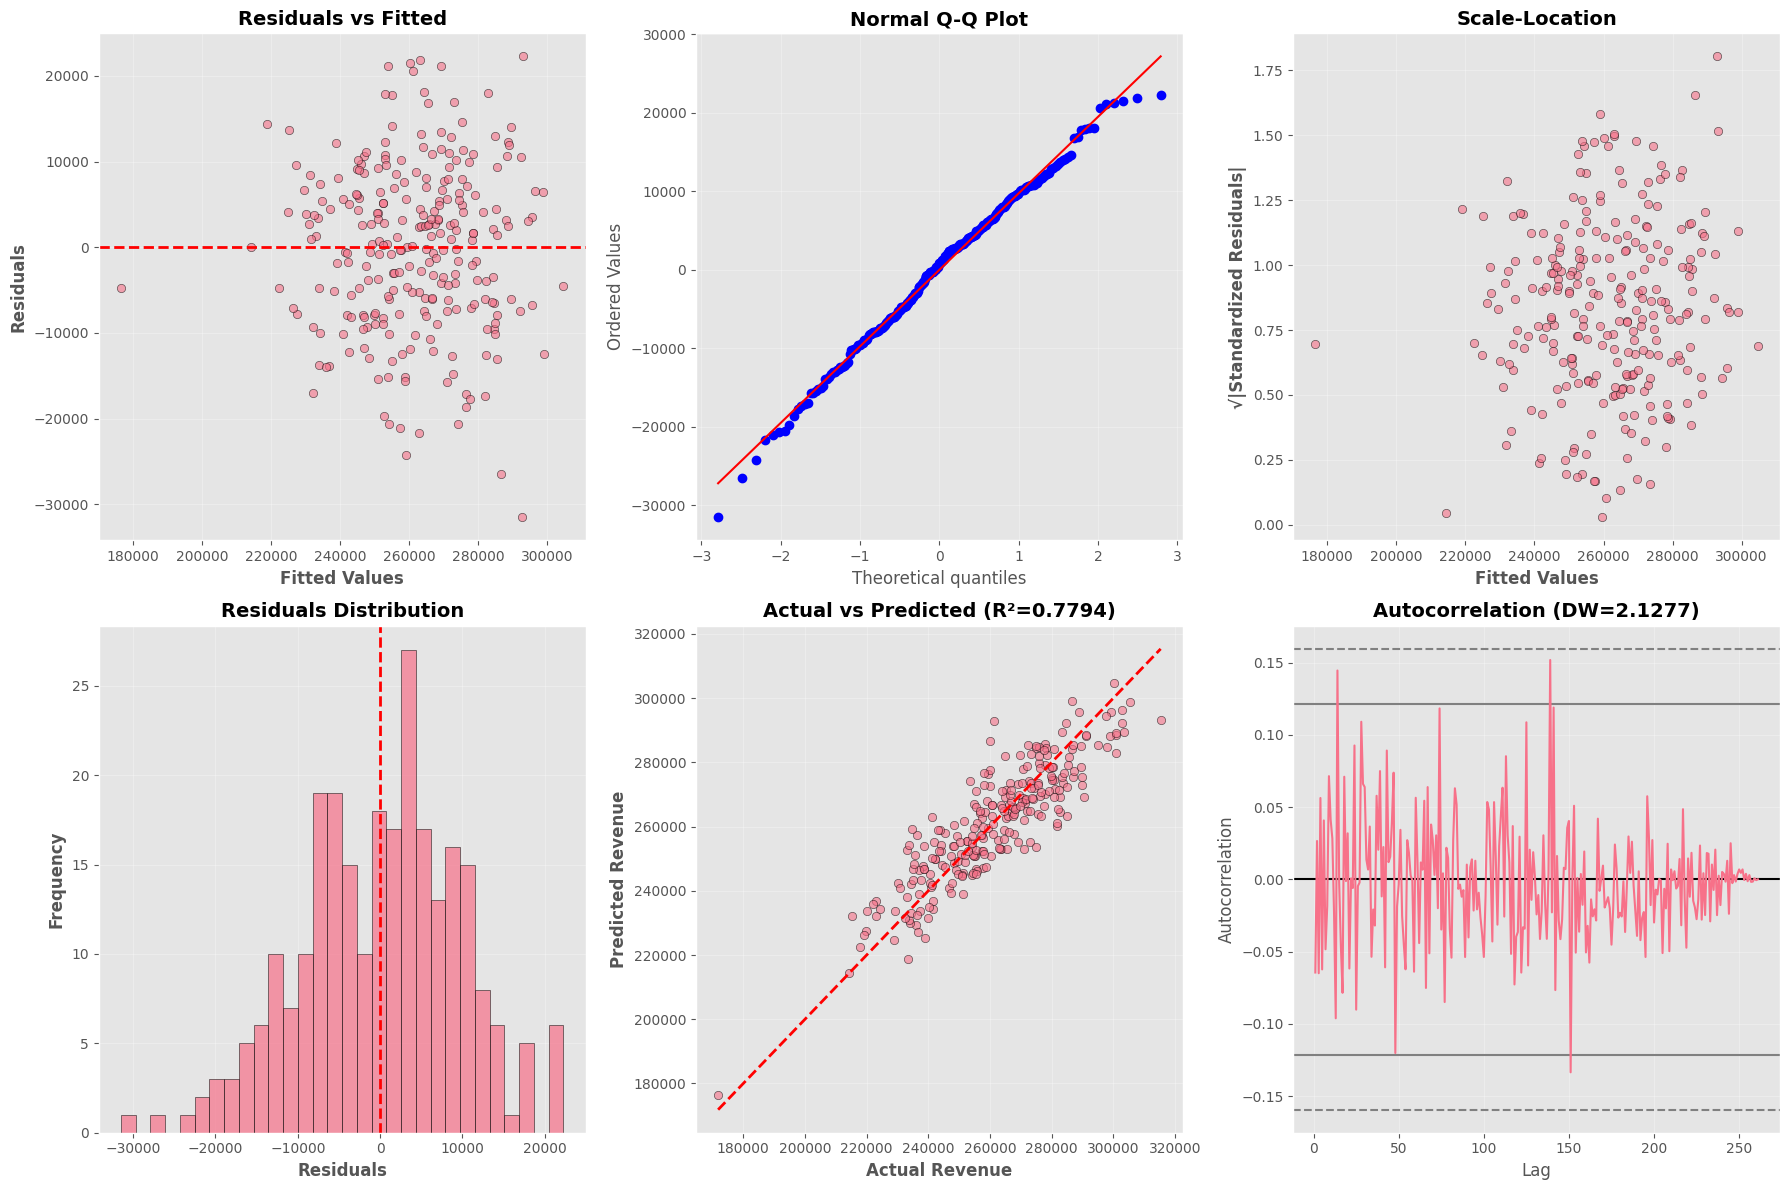


📋 FINAL SUMMARY: LINEAR REGRESSION ASSUMPTIONS

📊 Assumptions Check:
   1. Linearity: ✅ PASS
   2. Normality: ✅ PASS
   3. Homoscedasticity: ✅ PASS
   4. No Autocorrelation: ✅ PASS
   5. No Multicollinearity: ❌ FAIL

🎯 OVERALL RESULT: 4/5 assumptions passed

✅ LINEAR REGRESSION CÓ THỂ SỬ DỤNG
   → Nhưng vẫn nên so sánh với Non-linear models (Gradient Boosting)

💡 RECOMMENDATION:
   - VIF = inf → Perfect multicollinearity → Linear Regression SẼ THẤT BẠI
   - Sử dụng Gradient Boosting (không bị ảnh hưởng bởi multicollinearity)


In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.stattools import durbin_watson
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("=" * 80)
print("🔬 KIỂM TRA ASSUMPTIONS CHO LINEAR REGRESSION (WEEKLY_FULL)")
print("=" * 80)

# =============================================================================
# 1️⃣ CHUẨN BỊ DỮ LIỆU
# =============================================================================
print("\n1️⃣ Chuẩn bị dữ liệu")
print("-" * 80)

# Lấy all features (exclude 'week' và 'Revenue')
all_features = [col for col in weekly_full.columns if col not in ["week", "Revenue"]]

X = weekly_full[all_features].copy()
y = weekly_full["Revenue"].copy()

# Loại bỏ constant columns (nếu có)
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"⚠️ Loại bỏ {len(constant_cols)} constant columns: {constant_cols}")
    X = X.drop(columns=constant_cols)
    all_features = [col for col in all_features if col not in constant_cols]

print(f"✅ Dataset prepared:")
print(f"   - X shape: {X.shape}")
print(f"   - y shape: {y.shape}")
print(f"   - Features: {len(all_features)}")

# =============================================================================
# 2️⃣ TRAIN LINEAR REGRESSION
# =============================================================================
print("\n2️⃣ Training Linear Regression")
print("-" * 80)

# Add constant cho statsmodels
X_with_const = sm.add_constant(X)

# Fit model
model_sm = sm.OLS(y, X_with_const).fit()

# Predictions và residuals
y_pred = model_sm.predict(X_with_const)
residuals = y - y_pred

print(f"✅ Model trained:")
print(f"   - R²: {model_sm.rsquared:.4f}")
print(f"   - Adj R²: {model_sm.rsquared_adj:.4f}")
print(f"   - F-statistic: {model_sm.fvalue:.2f}")
print(f"   - Prob (F-statistic): {model_sm.f_pvalue:.4e}")

# =============================================================================
# 3️⃣ ASSUMPTION 1: LINEARITY (Spearman vs Pearson)
# =============================================================================
print("\n" + "=" * 80)
print("📊 ASSUMPTION 1: LINEARITY")
print("=" * 80)

from scipy.stats import pearsonr, spearmanr

linearity_results = []

for feature in all_features:
    # Pearson correlation (linear)
    pearson_r, pearson_p = pearsonr(X[feature], y)

    # Spearman correlation (monotonic, non-linear)
    spearman_r, spearman_p = spearmanr(X[feature], y)

    # Difference
    diff = abs(spearman_r - pearson_r)

    linearity_results.append(
        {
            "Feature": feature,
            "Pearson_r": pearson_r,
            "Spearman_r": spearman_r,
            "Difference": diff,
            "Is_Linear": "✅" if diff < 0.1 else "❌",
        }
    )

linearity_df = pd.DataFrame(linearity_results).sort_values(
    "Difference", ascending=False
)

print(f"\n📋 Top 10 features with highest non-linearity:")
print(linearity_df.head(10).to_string(index=False))

non_linear_count = (linearity_df["Difference"] >= 0.1).sum()
print(f"\n⚠️ Non-linear features: {non_linear_count}/{len(all_features)}")
print(
    f"   {'❌ FAIL' if non_linear_count > len(all_features) * 0.3 else '✅ PASS'} (threshold: 30%)"
)

# =============================================================================
# 4️⃣ ASSUMPTION 2: NORMALITY OF RESIDUALS
# =============================================================================
print("\n" + "=" * 80)
print("📊 ASSUMPTION 2: NORMALITY OF RESIDUALS")
print("=" * 80)

# Shapiro-Wilk test
shapiro_stat, shapiro_p = stats.shapiro(residuals)

# Jarque-Bera test - ✅ FIXED: chỉ trả về 2 giá trị
jb_stat, jb_p = stats.jarque_bera(residuals)

# Tính skewness và kurtosis riêng
skew = stats.skew(residuals)
kurtosis = stats.kurtosis(residuals)

# Anderson-Darling test
anderson_result = stats.anderson(residuals, dist="norm")

print(f"\n📊 Normality Tests:")
print(f"   Shapiro-Wilk:")
print(f"      - Statistic: {shapiro_stat:.4f}")
print(f"      - P-value: {shapiro_p:.4e}")
print(f"      - Result: {'✅ PASS' if shapiro_p > 0.05 else '❌ FAIL'}")

print(f"\n   Jarque-Bera:")
print(f"      - Statistic: {jb_stat:.4f}")
print(f"      - P-value: {jb_p:.4e}")
print(f"      - Skewness: {skew:.4f}")
print(f"      - Kurtosis: {kurtosis:.4f}")
print(f"      - Result: {'✅ PASS' if jb_p > 0.05 else '❌ FAIL'}")

print(f"\n   Anderson-Darling:")
print(f"      - Statistic: {anderson_result.statistic:.4f}")
print(f"      - Critical value (5%): {anderson_result.critical_values[2]:.4f}")
print(
    f"      - Result: {'✅ PASS' if anderson_result.statistic < anderson_result.critical_values[2] else '❌ FAIL'}"
)

# Overall normality
normality_pass = shapiro_p > 0.05 and jb_p > 0.05
print(f"\n🎯 OVERALL: {'✅ PASS' if normality_pass else '❌ FAIL'}")

# =============================================================================
# 5️⃣ ASSUMPTION 3: HOMOSCEDASTICITY (Equal Variance)
# =============================================================================
print("\n" + "=" * 80)
print("📊 ASSUMPTION 3: HOMOSCEDASTICITY")
print("=" * 80)

# Breusch-Pagan test
bp_test = het_breuschpagan(residuals, X_with_const)
bp_stat, bp_p, bp_f, bp_f_p = bp_test

# White test
white_test = het_white(residuals, X_with_const)
white_stat, white_p, white_f, white_f_p = white_test

print(f"\n📊 Heteroscedasticity Tests:")
print(f"   Breusch-Pagan:")
print(f"      - LM Statistic: {bp_stat:.4f}")
print(f"      - P-value: {bp_p:.4e}")
print(
    f"      - Result: {'✅ PASS (Homoscedastic)' if bp_p > 0.05 else '❌ FAIL (Heteroscedastic)'}"
)

print(f"\n   White:")
print(f"      - LM Statistic: {white_stat:.4f}")
print(f"      - P-value: {white_p:.4e}")
print(
    f"      - Result: {'✅ PASS (Homoscedastic)' if white_p > 0.05 else '❌ FAIL (Heteroscedastic)'}"
)

homoscedasticity_pass = bp_p > 0.05 and white_p > 0.05
print(f"\n🎯 OVERALL: {'✅ PASS' if homoscedasticity_pass else '❌ FAIL'}")

# =============================================================================
# 6️⃣ ASSUMPTION 4: NO AUTOCORRELATION (Durbin-Watson)
# =============================================================================
print("\n" + "=" * 80)
print("📊 ASSUMPTION 4: NO AUTOCORRELATION")
print("=" * 80)

dw_stat = durbin_watson(residuals)

print(f"\n📊 Durbin-Watson Test:")
print(f"   - Statistic: {dw_stat:.4f}")
print(f"   - Interpretation:")
print(f"      • 1.5 < DW < 2.5: No autocorrelation ✅")
print(f"      • DW < 1.5: Positive autocorrelation ⚠️")
print(f"      • DW > 2.5: Negative autocorrelation ⚠️")

if 1.5 <= dw_stat <= 2.5:
    print(f"\n   - Result: ✅ PASS (No significant autocorrelation)")
    autocorr_pass = True
else:
    print(f"\n   - Result: ❌ FAIL (Autocorrelation detected)")
    autocorr_pass = False

# =============================================================================
# 7️⃣ ASSUMPTION 5: NO MULTICOLLINEARITY (VIF)
# =============================================================================
print("\n" + "=" * 80)
print("📊 ASSUMPTION 5: NO MULTICOLLINEARITY (VIF)")
print("=" * 80)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = all_features
vif_data["VIF"] = [
    variance_inflation_factor(X.values, i) for i in range(len(all_features))
]
vif_data = vif_data.sort_values("VIF", ascending=False)

print(f"\n📊 Top 10 features by VIF:")
print(vif_data.head(10).to_string(index=False))

# Count high VIF features
high_vif_count = (vif_data["VIF"] > 10).sum()
inf_vif_count = (vif_data["VIF"] == np.inf).sum()

print(f"\n⚠️ Multicollinearity Summary:")
print(f"   - Features with VIF > 10: {high_vif_count}")
print(f"   - Features with VIF = inf: {inf_vif_count}")
print(f"   - Result: {'✅ PASS' if high_vif_count == 0 else '❌ FAIL'}")

multicollinearity_pass = high_vif_count == 0

# =============================================================================
# 8️⃣ VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("📊 CREATING DIAGNOSTIC PLOTS")
print("=" * 80)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Residuals vs Fitted
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors="k")
axes[0, 0].axhline(y=0, color="r", linestyle="--", linewidth=2)
axes[0, 0].set_xlabel("Fitted Values", fontweight="bold")
axes[0, 0].set_ylabel("Residuals", fontweight="bold")
axes[0, 0].set_title("Residuals vs Fitted", fontweight="bold", fontsize=14)
axes[0, 0].grid(True, alpha=0.3)

# 2. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Normal Q-Q Plot", fontweight="bold", fontsize=14)
axes[0, 1].grid(True, alpha=0.3)

# 3. Scale-Location
standardized_residuals = residuals / np.std(residuals)
axes[0, 2].scatter(
    y_pred, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, edgecolors="k"
)
axes[0, 2].set_xlabel("Fitted Values", fontweight="bold")
axes[0, 2].set_ylabel("√|Standardized Residuals|", fontweight="bold")
axes[0, 2].set_title("Scale-Location", fontweight="bold", fontsize=14)
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals Histogram
axes[1, 0].hist(residuals, bins=30, edgecolor="black", alpha=0.7)
axes[1, 0].axvline(x=0, color="r", linestyle="--", linewidth=2)
axes[1, 0].set_xlabel("Residuals", fontweight="bold")
axes[1, 0].set_ylabel("Frequency", fontweight="bold")
axes[1, 0].set_title("Residuals Distribution", fontweight="bold", fontsize=14)
axes[1, 0].grid(True, alpha=0.3)

# 5. Actual vs Predicted
axes[1, 1].scatter(y, y_pred, alpha=0.6, edgecolors="k")
axes[1, 1].plot([y.min(), y.max()], [y.min(), y.max()], "r--", linewidth=2)
axes[1, 1].set_xlabel("Actual Revenue", fontweight="bold")
axes[1, 1].set_ylabel("Predicted Revenue", fontweight="bold")
axes[1, 1].set_title(
    f"Actual vs Predicted (R²={model_sm.rsquared:.4f})", fontweight="bold", fontsize=14
)
axes[1, 1].grid(True, alpha=0.3)

# 6. Autocorrelation Plot
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(residuals, ax=axes[1, 2])
axes[1, 2].set_title(
    f"Autocorrelation (DW={dw_stat:.4f})", fontweight="bold", fontsize=14
)
axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# =============================================================================
# 9️⃣ FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("📋 FINAL SUMMARY: LINEAR REGRESSION ASSUMPTIONS")
print("=" * 80)

assumptions = {
    "1. Linearity": (
        "✅ PASS" if non_linear_count <= len(all_features) * 0.3 else "❌ FAIL"
    ),
    "2. Normality": "✅ PASS" if normality_pass else "❌ FAIL",
    "3. Homoscedasticity": "✅ PASS" if homoscedasticity_pass else "❌ FAIL",
    "4. No Autocorrelation": "✅ PASS" if autocorr_pass else "❌ FAIL",
    "5. No Multicollinearity": "✅ PASS" if multicollinearity_pass else "❌ FAIL",
}

print("\n📊 Assumptions Check:")
for assumption, result in assumptions.items():
    print(f"   {assumption}: {result}")

# Overall decision
passed_count = sum([1 for v in assumptions.values() if "PASS" in v])
total_count = len(assumptions)

print(f"\n🎯 OVERALL RESULT: {passed_count}/{total_count} assumptions passed")

if passed_count >= 4:
    print("\n✅ LINEAR REGRESSION CÓ THỂ SỬ DỤNG")
    print("   → Nhưng vẫn nên so sánh với Non-linear models (Gradient Boosting)")
elif passed_count >= 2:
    print("\n⚠️ LINEAR REGRESSION CÓ THỂ SỬ DỤNG NHƯNG KHÔNG TỐI ƯU")
    print("   → Nên ưu tiên Non-linear models (Gradient Boosting, Random Forest)")
else:
    print("\n❌ LINEAR REGRESSION KHÔNG PHÙ HỢP")
    print("   → BẮT BUỘC sử dụng Non-linear models (Gradient Boosting, XGBoost)")

print("\n💡 RECOMMENDATION:")
if inf_vif_count > 0:
    print("   - VIF = inf → Perfect multicollinearity → Linear Regression SẼ THẤT BẠI")
    print("   - Sử dụng Gradient Boosting (không bị ảnh hưởng bởi multicollinearity)")
else:
    print("   - Train cả Linear Regression VÀ Gradient Boosting")
    print("   - So sánh R², MAE, RMSE để chọn model tốt nhất")

print("=" * 80)

Chua co LAG feature

🌲 RANDOM FOREST REGRESSION - REVENUE FORECASTING

1️⃣ Chuẩn bị dữ liệu
--------------------------------------------------------------------------------
✅ Dataset prepared:
   - X shape: (261, 24)
   - y shape: (261,)
   - Features: 24
   - Revenue range: $171,833 - $315,326

2️⃣ Train-Test Split
--------------------------------------------------------------------------------
✅ Split completed:
   - Train: 208 weeks (79.7%)
   - Test:  53 weeks (20.3%)
   - Train revenue: $54,408,804
   - Test revenue:  $13,771,200

3️⃣ BASELINE RANDOM FOREST (Default Parameters)

📊 TRAIN (Baseline) Metrics:
   - R²:    0.9513
   - MAE:   $3,519.60
   - RMSE:  $4,693.11
   - MAPE:  1.37%

📊 TEST (Baseline) Metrics:
   - R²:    0.6129
   - MAE:   $9,040.20
   - RMSE:  $11,104.12
   - MAPE:  3.46%

⚠️ Overfitting Check:
   - R² gap: 0.3383
   - Status: ⚠️ OVERFITTING DETECTED

4️⃣ HYPERPARAMETER TUNING (Grid Search)
🔍 Testing 216 combinations...
   Parameters: ['n_estimators', 'max_depth', 'min_samples_sp

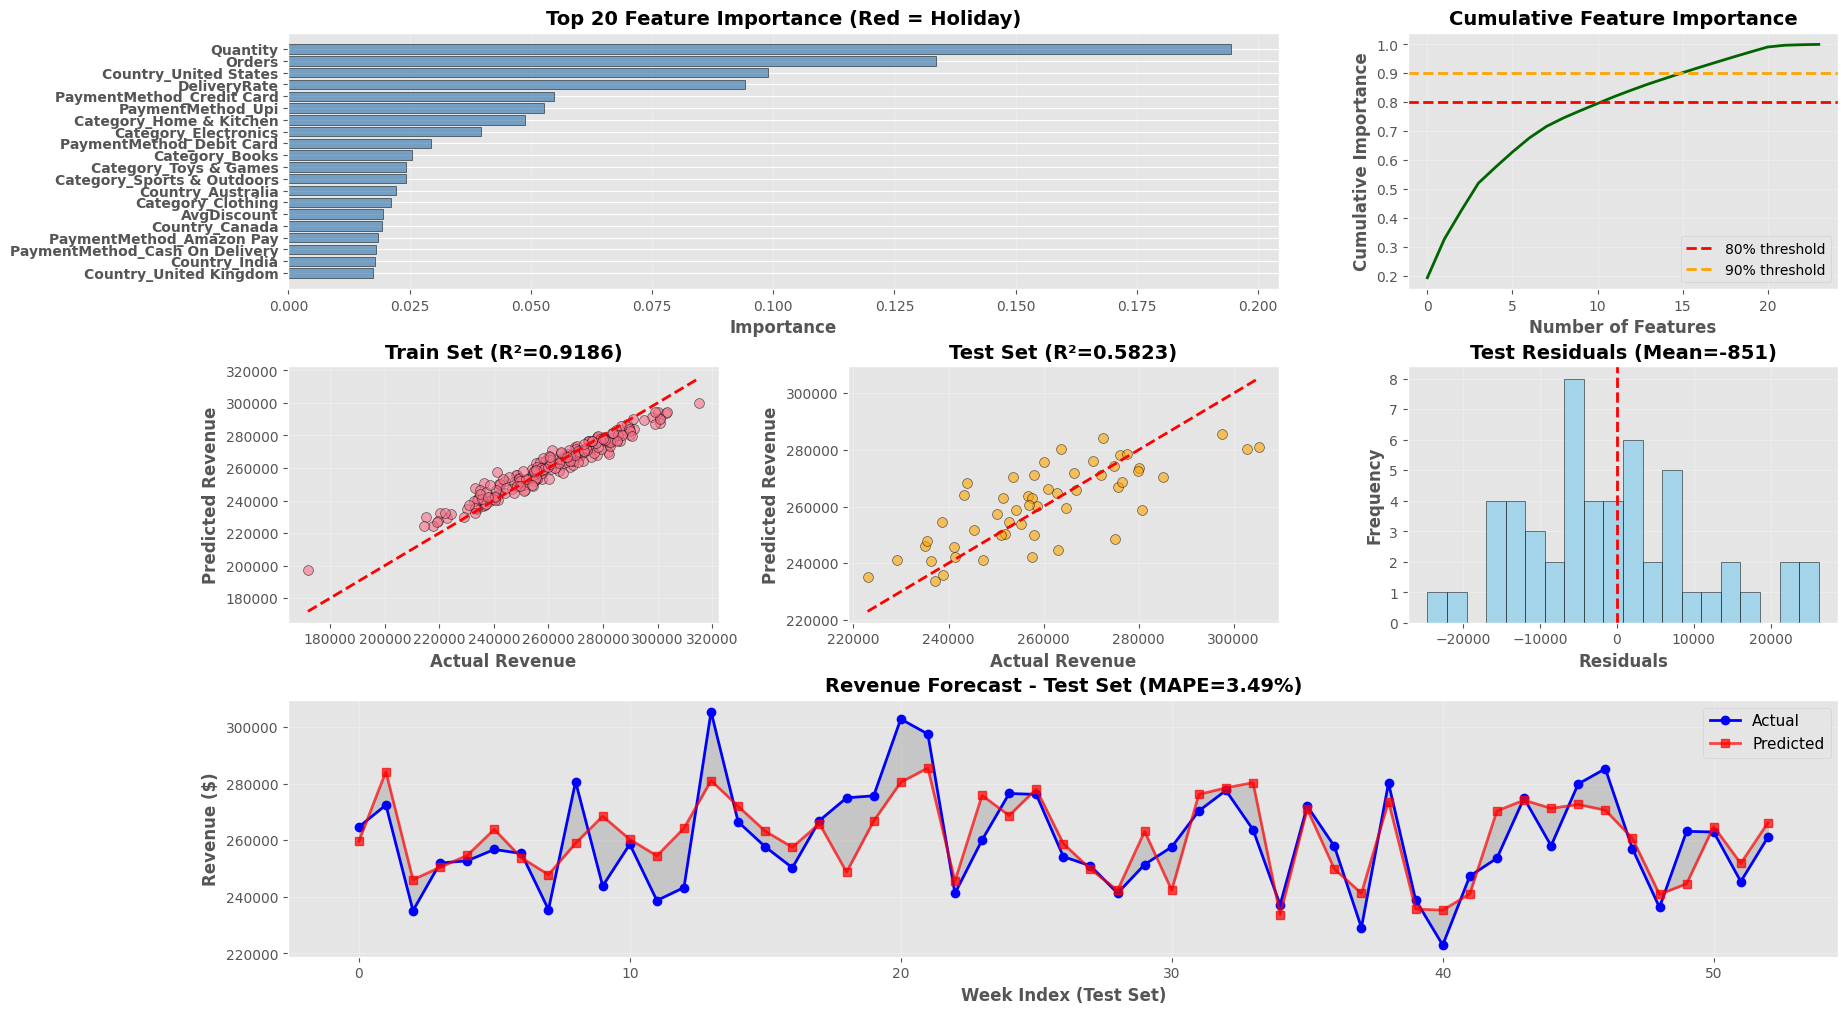


📋 FINAL SUMMARY - RANDOM FOREST MODEL

🎯 MODEL PERFORMANCE:
   Metric          Train           Test           
   ---------------------------------------------
   R²              0.9186          0.5823         
   MAE             $4,643.73       $9,106.20      
   RMSE            $6,065.22       $11,535.73     
   MAPE            1.81          % 3.49          %

🌲 MODEL CONFIGURATION:
   - Number of trees: 200
   - Max depth: 30
   - Min samples split: 5
   - Min samples leaf: 1
   - Max features: sqrt

📊 FEATURE STATISTICS:
   - Total features: 24
   - Features for 80% importance: 12
   - Features for 90% importance: 16
   - Top feature: Quantity (0.1945)

✅ CONCLUSION:
   - ⚠️ ACCEPTABLE model (R² >= 0.4)
   - ⚠️ Some overfitting detected

💡 ADVANTAGES OF RANDOM FOREST:
   ✅ Không bị ảnh hưởng bởi multicollinearity (VIF = inf không quan trọng)
   ✅ Tự động xử lý non-linear relationships
   ✅ Feature importance rõ ràng
   ✅ Robust với outliers và missing values
   ✅ Không cần feature

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")

print("=" * 80)
print("🌲 RANDOM FOREST REGRESSION - REVENUE FORECASTING")
print("=" * 80)

# =============================================================================
# 1️⃣ CHUẨN BỊ DỮ LIỆU
# =============================================================================
print("\n1️⃣ Chuẩn bị dữ liệu")
print("-" * 80)

# Lấy features và target
all_features = [col for col in weekly_full.columns if col not in ["week", "Revenue"]]
X = weekly_full[all_features].copy()
y = weekly_full["Revenue"].copy()

# Loại bỏ constant columns
constant_cols = [col for col in X.columns if X[col].nunique() == 1]
if constant_cols:
    print(f"⚠️ Loại bỏ {len(constant_cols)} constant columns")
    X = X.drop(columns=constant_cols)
    all_features = [col for col in all_features if col not in constant_cols]

print(f"✅ Dataset prepared:")
print(f"   - X shape: {X.shape}")
print(f"   - y shape: {y.shape}")
print(f"   - Features: {len(all_features)}")
print(f"   - Revenue range: ${y.min():,.0f} - ${y.max():,.0f}")

# =============================================================================
# 2️⃣ TRAIN-TEST SPLIT (80-20)
# =============================================================================
print("\n2️⃣ Train-Test Split")
print("-" * 80)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # Time series: shuffle=False
)

print(f"✅ Split completed:")
print(f"   - Train: {len(X_train)} weeks ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test:  {len(X_test)} weeks ({len(X_test)/len(X)*100:.1f}%)")
print(f"   - Train revenue: ${y_train.sum():,.0f}")
print(f"   - Test revenue:  ${y_test.sum():,.0f}")

# =============================================================================
# 3️⃣ BASELINE MODEL - DEFAULT PARAMETERS
# =============================================================================
print("\n" + "=" * 80)
print("3️⃣ BASELINE RANDOM FOREST (Default Parameters)")
print("=" * 80)

# Train baseline model
rf_baseline = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

# Predictions
y_train_pred_baseline = rf_baseline.predict(X_train)
y_test_pred_baseline = rf_baseline.predict(X_test)


# Metrics
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"\n📊 {dataset_name} Metrics:")
    print(f"   - R²:    {r2:.4f}")
    print(f"   - MAE:   ${mae:,.2f}")
    print(f"   - RMSE:  ${rmse:,.2f}")
    print(f"   - MAPE:  {mape:.2f}%")

    return {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE": mape}


baseline_train = evaluate_model(y_train, y_train_pred_baseline, "TRAIN (Baseline)")
baseline_test = evaluate_model(y_test, y_test_pred_baseline, "TEST (Baseline)")

# Overfitting check
print(f"\n⚠️ Overfitting Check:")
print(f"   - R² gap: {baseline_train['R2'] - baseline_test['R2']:.4f}")
if baseline_train["R2"] - baseline_test["R2"] > 0.1:
    print(f"   - Status: ⚠️ OVERFITTING DETECTED")
else:
    print(f"   - Status: ✅ Good generalization")

# =============================================================================
# 4️⃣ HYPERPARAMETER TUNING (GRID SEARCH)
# =============================================================================
print("\n" + "=" * 80)
print("4️⃣ HYPERPARAMETER TUNING (Grid Search)")
print("=" * 80)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"],
}

print(f"🔍 Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")
print(f"   Parameters: {list(param_grid.keys())}")

# Grid Search với Cross-Validation
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")

print(f"\n📊 Best Cross-Validation R²: {grid_search.best_score_:.4f}")

# =============================================================================
# 5️⃣ FINAL MODEL - BEST PARAMETERS
# =============================================================================
print("\n" + "=" * 80)
print("5️⃣ FINAL RANDOM FOREST MODEL (Tuned)")
print("=" * 80)

# Train final model
rf_final = grid_search.best_estimator_
y_train_pred_final = rf_final.predict(X_train)
y_test_pred_final = rf_final.predict(X_test)

# Evaluate
final_train = evaluate_model(y_train, y_train_pred_final, "TRAIN (Tuned)")
final_test = evaluate_model(y_test, y_test_pred_final, "TEST (Tuned)")

# Improvement
print(f"\n📈 IMPROVEMENT vs Baseline:")
print(f"   - R² improvement:  {(final_test['R2'] - baseline_test['R2']):.4f}")
print(f"   - MAE improvement: ${(baseline_test['MAE'] - final_test['MAE']):,.2f}")
print(f"   - RMSE improvement: ${(baseline_test['RMSE'] - final_test['RMSE']):,.2f}")

# =============================================================================
# 6️⃣ FEATURE IMPORTANCE ANALYSIS
# =============================================================================
print("\n" + "=" * 80)
print("6️⃣ FEATURE IMPORTANCE ANALYSIS")
print("=" * 80)

# Get feature importance
feature_importance = pd.DataFrame(
    {"Feature": X.columns, "Importance": rf_final.feature_importances_}
).sort_values("Importance", ascending=False)

print(f"\n📊 Top 20 Most Important Features:")
print(feature_importance.head(20).to_string(index=False))

# Phân loại features
numeric_features = [
    "Orders",
    "Quantity",
    "AvgDiscount",
    "DeliveryRate",
    "HolidayDays",
    "HolidayRevenue",
    "has_holiday",
]

top20_features = feature_importance.head(20)["Feature"].tolist()
numeric_in_top20 = [f for f in top20_features if f in numeric_features]
categorical_in_top20 = [f for f in top20_features if f not in numeric_features]

print(f"\n📋 Feature Type Breakdown (Top 20):")
print(f"   - Numeric features: {len(numeric_in_top20)}")
for feat in numeric_in_top20:
    imp = feature_importance[feature_importance["Feature"] == feat][
        "Importance"
    ].values[0]
    emoji = "🎄" if "holiday" in feat.lower() else "  "
    print(f"     {emoji}• {feat}: {imp:.4f}")

print(f"\n   - Categorical features: {len(categorical_in_top20)}")
for feat in categorical_in_top20[:5]:
    imp = feature_importance[feature_importance["Feature"] == feat][
        "Importance"
    ].values[0]
    print(f"      • {feat}: {imp:.4f}")
if len(categorical_in_top20) > 5:
    print(f"      ... and {len(categorical_in_top20) - 5} more")

# =============================================================================
# 7️⃣ VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("7️⃣ CREATING VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Feature Importance (Top 20)
ax1 = fig.add_subplot(gs[0, :2])
top20 = feature_importance.head(20)
colors_imp = [
    "red" if "holiday" in str(f).lower() else "steelblue" for f in top20["Feature"]
]
ax1.barh(
    range(len(top20)),
    top20["Importance"],
    color=colors_imp,
    alpha=0.7,
    edgecolor="black",
)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20["Feature"], fontsize=10, fontweight="bold")
ax1.set_xlabel("Importance", fontweight="bold", fontsize=12)
ax1.set_title(
    "Top 20 Feature Importance (Red = Holiday)", fontweight="bold", fontsize=14
)
ax1.grid(True, alpha=0.3, axis="x")
ax1.invert_yaxis()

# 2. Cumulative Importance
ax2 = fig.add_subplot(gs[0, 2])
cumsum = feature_importance["Importance"].cumsum()
ax2.plot(range(len(cumsum)), cumsum, linewidth=2, color="darkgreen")
ax2.axhline(y=0.8, color="red", linestyle="--", linewidth=2, label="80% threshold")
ax2.axhline(y=0.9, color="orange", linestyle="--", linewidth=2, label="90% threshold")
ax2.set_xlabel("Number of Features", fontweight="bold")
ax2.set_ylabel("Cumulative Importance", fontweight="bold")
ax2.set_title("Cumulative Feature Importance", fontweight="bold", fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Actual vs Predicted (Train)
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_train, y_train_pred_final, alpha=0.6, edgecolors="k", s=50)
ax3.plot(
    [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", linewidth=2
)
ax3.set_xlabel("Actual Revenue", fontweight="bold")
ax3.set_ylabel("Predicted Revenue", fontweight="bold")
ax3.set_title(f'Train Set (R²={final_train["R2"]:.4f})', fontweight="bold", fontsize=14)
ax3.grid(True, alpha=0.3)

# 4. Actual vs Predicted (Test)
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_test, y_test_pred_final, alpha=0.6, edgecolors="k", s=50, color="orange")
ax4.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
ax4.set_xlabel("Actual Revenue", fontweight="bold")
ax4.set_ylabel("Predicted Revenue", fontweight="bold")
ax4.set_title(f'Test Set (R²={final_test["R2"]:.4f})', fontweight="bold", fontsize=14)
ax4.grid(True, alpha=0.3)

# 5. Residuals Distribution (Test)
ax5 = fig.add_subplot(gs[1, 2])
residuals_test = y_test - y_test_pred_final
ax5.hist(residuals_test, bins=20, edgecolor="black", alpha=0.7, color="skyblue")
ax5.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax5.set_xlabel("Residuals", fontweight="bold")
ax5.set_ylabel("Frequency", fontweight="bold")
ax5.set_title(
    f"Test Residuals (Mean={residuals_test.mean():.0f})", fontweight="bold", fontsize=14
)
ax5.grid(True, alpha=0.3)

# 6. Time Series Plot (Test)
ax6 = fig.add_subplot(gs[2, :])
test_weeks = range(len(y_test))
ax6.plot(
    test_weeks, y_test.values, marker="o", linewidth=2, label="Actual", color="blue"
)
ax6.plot(
    test_weeks,
    y_test_pred_final,
    marker="s",
    linewidth=2,
    label="Predicted",
    color="red",
    alpha=0.7,
)
ax6.fill_between(test_weeks, y_test.values, y_test_pred_final, alpha=0.3, color="gray")
ax6.set_xlabel("Week Index (Test Set)", fontweight="bold", fontsize=12)
ax6.set_ylabel("Revenue ($)", fontweight="bold", fontsize=12)
ax6.set_title(
    f'Revenue Forecast - Test Set (MAPE={final_test["MAPE"]:.2f}%)',
    fontweight="bold",
    fontsize=14,
)
ax6.legend(fontsize=11, loc="best")
ax6.grid(True, alpha=0.3)

plt.show()

# =============================================================================
# 8️⃣ FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("📋 FINAL SUMMARY - RANDOM FOREST MODEL")
print("=" * 80)

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   {'Metric':<15} {'Train':<15} {'Test':<15}")
print(f"   {'-'*45}")
print(f"   {'R²':<15} {final_train['R2']:<15.4f} {final_test['R2']:<15.4f}")
print(f"   {'MAE':<15} ${final_train['MAE']:<14,.2f} ${final_test['MAE']:<14,.2f}")
print(f"   {'RMSE':<15} ${final_train['RMSE']:<14,.2f} ${final_test['RMSE']:<14,.2f}")
print(f"   {'MAPE':<15} {final_train['MAPE']:<14.2f}% {final_test['MAPE']:<14.2f}%")

print(f"\n🌲 MODEL CONFIGURATION:")
print(f"   - Number of trees: {rf_final.n_estimators}")
print(f"   - Max depth: {rf_final.max_depth}")
print(f"   - Min samples split: {rf_final.min_samples_split}")
print(f"   - Min samples leaf: {rf_final.min_samples_leaf}")
print(f"   - Max features: {rf_final.max_features}")

print(f"\n📊 FEATURE STATISTICS:")
print(f"   - Total features: {len(all_features)}")
print(f"   - Features for 80% importance: {(cumsum >= 0.8).argmax() + 1}")
print(f"   - Features for 90% importance: {(cumsum >= 0.9).argmax() + 1}")
print(
    f"   - Top feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})"
)

print(f"\n✅ CONCLUSION:")
if final_test["R2"] >= 0.8:
    print(f"   - ⭐ EXCELLENT model (R² >= 0.8)")
elif final_test["R2"] >= 0.6:
    print(f"   - ✅ GOOD model (R² >= 0.6)")
elif final_test["R2"] >= 0.4:
    print(f"   - ⚠️ ACCEPTABLE model (R² >= 0.4)")
else:
    print(f"   - ❌ POOR model (R² < 0.4)")

if final_train["R2"] - final_test["R2"] > 0.1:
    print(f"   - ⚠️ Some overfitting detected")
else:
    print(f"   - ✅ No significant overfitting")

print(f"\n💡 ADVANTAGES OF RANDOM FOREST:")
print(f"   ✅ Không bị ảnh hưởng bởi multicollinearity (VIF = inf không quan trọng)")
print(f"   ✅ Tự động xử lý non-linear relationships")
print(f"   ✅ Feature importance rõ ràng")
print(f"   ✅ Robust với outliers và missing values")
print(f"   ✅ Không cần feature scaling")

print("=" * 80)

🌲 RANDOM FOREST WITH TRAIN-VALIDATION-TEST SPLIT

1️⃣ Advanced Feature Engineering
--------------------------------------------------------------------------------

📊 Creating LAG features...
📊 Creating ROLLING features...
📊 Creating TREND features...
📊 Creating INTERACTION features...

✅ Feature Engineering completed:
   - Original features: 24
   - New features: 48
   - Samples: 253 (from 261)

2️⃣ TRAIN-VALIDATION-TEST SPLIT (60-20-20)

✅ Split completed:
   - TRAIN:      151 weeks (59.7%)
   - VALIDATION: 51 weeks (20.2%)
   - TEST:       51 weeks (20.2%)

   Revenue distribution:
   - Train:      $39,578,242
   - Validation: $13,312,938
   - Test:       $13,234,108

3️⃣ HYPERPARAMETER TUNING (Grid Search on TRAIN)
🔍 Testing 648 combinations...
Fitting 5 folds for each of 648 candidates, totalling 3240 fits

✅ Best Parameters:
   - max_depth: 15
   - max_features: 0.5
   - max_samples: 1.0
   - min_samples_leaf: 2
   - min_samples_split: 5
   - n_estimators: 300

📊 Best CV R² (on T

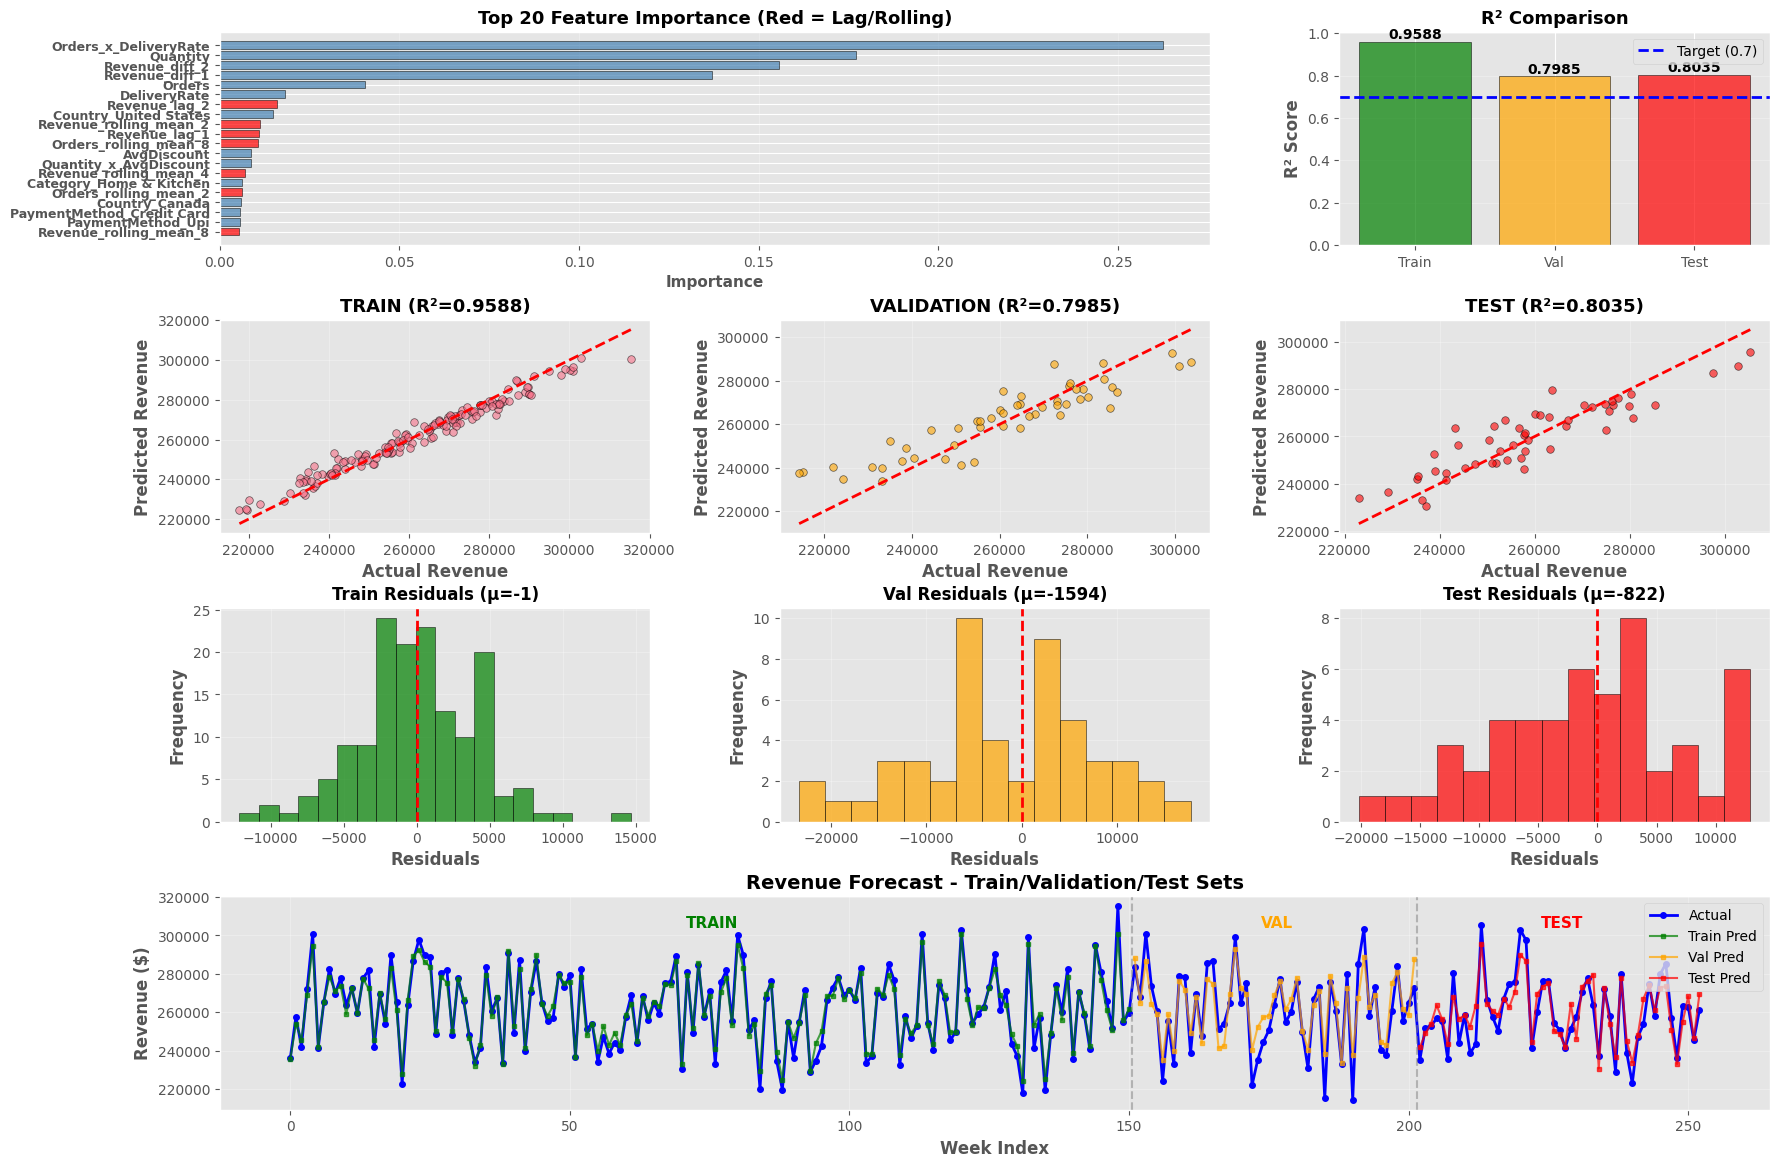


📋 FINAL SUMMARY - RANDOM FOREST MODEL

🎯 MODEL PERFORMANCE (All 3 Sets):
   Metric          Train           Validation      Test           
   ------------------------------------------------------------
   R²              0.9588          0.7985          0.8035         
   MAE             $3,149          $7,758          $6,385         
   RMSE            $4,057          $9,561          $8,020         
   MAPE            1.21          % 3.06          % 2.47          %

📊 OVERFITTING ASSESSMENT:
   - Overfitting Status: ❌ POOR
   - Generalization:     ✅ EXCELLENT
   - Train-Val Gap:      +0.1604
   - Train-Test Gap:     +0.1553

🌲 MODEL CONFIGURATION:
   - Number of trees:     300
   - Max depth:           15
   - Min samples split:   5
   - Min samples leaf:    2
   - Max features:        0.5
   - Max samples:         1.0

✅ GOAL CHECK:
   🎉 SUCCESS! Test R² = 0.8035 >= 0.7

💡 KEY INSIGHTS:
   ✅ LAG features contribute significantly to predictions
   ✅ 3-way split (Train/Val/Test) prov

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")

print("=" * 80)
print("🌲 RANDOM FOREST WITH TRAIN-VALIDATION-TEST SPLIT")
print("=" * 80)

# =============================================================================
# 1️⃣ FEATURE ENGINEERING
# =============================================================================
print("\n1️⃣ Advanced Feature Engineering")
print("-" * 80)

all_features = [col for col in weekly_full.columns if col not in ["week", "Revenue"]]
X_base = weekly_full[all_features].copy()
y = weekly_full["Revenue"].copy()

# Loại bỏ constant columns
constant_cols = [col for col in X_base.columns if X_base[col].nunique() == 1]
if constant_cols:
    X_base = X_base.drop(columns=constant_cols)

# LAG FEATURES
print("\n📊 Creating LAG features...")
for lag in [1, 2, 3, 4]:
    X_base[f"Revenue_lag_{lag}"] = y.shift(lag)
    X_base[f"Orders_lag_{lag}"] = X_base["Orders"].shift(lag)

# ROLLING FEATURES
print("📊 Creating ROLLING features...")
for window in [2, 4, 8]:
    X_base[f"Revenue_rolling_mean_{window}"] = y.shift(1).rolling(window=window).mean()
    X_base[f"Revenue_rolling_std_{window}"] = y.shift(1).rolling(window=window).std()
    X_base[f"Orders_rolling_mean_{window}"] = (
        X_base["Orders"].shift(1).rolling(window=window).mean()
    )

# TREND FEATURES
print("📊 Creating TREND features...")
X_base["week_index"] = range(len(X_base))
X_base["Revenue_diff_1"] = y.diff(1)
X_base["Revenue_diff_2"] = y.diff(2)

# INTERACTION FEATURES
print("📊 Creating INTERACTION features...")
X_base["Orders_x_DeliveryRate"] = X_base["Orders"] * X_base["DeliveryRate"]
X_base["Quantity_x_AvgDiscount"] = X_base["Quantity"] * X_base["AvgDiscount"]
X_base["has_holiday_x_Orders"] = X_base["has_holiday"] * X_base["Orders"]
X_base["has_holiday_x_Quantity"] = X_base["has_holiday"] * X_base["Quantity"]

# Drop NaN
X_engineered = X_base.dropna()
y_engineered = y.loc[X_engineered.index]

print(f"\n✅ Feature Engineering completed:")
print(f"   - Original features: {len(all_features)}")
print(f"   - New features: {X_engineered.shape[1]}")
print(f"   - Samples: {len(X_engineered)} (from {len(weekly_full)})")

# =============================================================================
# 2️⃣ TRAIN-VALIDATION-TEST SPLIT (60-20-20)
# =============================================================================
print("\n" + "=" * 80)
print("2️⃣ TRAIN-VALIDATION-TEST SPLIT (60-20-20)")
print("=" * 80)

# Time series split: không shuffle!
n = len(X_engineered)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X_engineered.iloc[:train_end]
y_train = y_engineered.iloc[:train_end]

X_val = X_engineered.iloc[train_end:val_end]
y_val = y_engineered.iloc[train_end:val_end]

X_test = X_engineered.iloc[val_end:]
y_test = y_engineered.iloc[val_end:]

print(f"\n✅ Split completed:")
print(f"   - TRAIN:      {len(X_train)} weeks ({len(X_train)/n*100:.1f}%)")
print(f"   - VALIDATION: {len(X_val)} weeks ({len(X_val)/n*100:.1f}%)")
print(f"   - TEST:       {len(X_test)} weeks ({len(X_test)/n*100:.1f}%)")
print(f"\n   Revenue distribution:")
print(f"   - Train:      ${y_train.sum():,.0f}")
print(f"   - Validation: ${y_val.sum():,.0f}")
print(f"   - Test:       ${y_test.sum():,.0f}")

# =============================================================================
# 3️⃣ HYPERPARAMETER TUNING (trên TRAIN, đánh giá trên VALIDATION)
# =============================================================================
print("\n" + "=" * 80)
print("3️⃣ HYPERPARAMETER TUNING (Grid Search on TRAIN)")
print("=" * 80)

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [15, 20, 25, 30],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2", 0.5],
    "max_samples": [0.8, 0.9, 1.0],
}

print(f"🔍 Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True),
    param_grid,
    cv=5,  # Cross-validation CHẢY trên TRAIN
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n📊 Best CV R² (on TRAIN): {grid_search.best_score_:.4f}")

# =============================================================================
# 4️⃣ ĐÁNH GIÁ MÔ HÌNH TRÊN CẢ 3 TẬP
# =============================================================================
print("\n" + "=" * 80)
print("4️⃣ MODEL EVALUATION ON ALL 3 SETS")
print("=" * 80)

rf_final = grid_search.best_estimator_

# Predictions
y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)


# Evaluation function
def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"\n📊 {dataset_name}:")
    print(f"   - R²:    {r2:.4f}")
    print(f"   - MAE:   ${mae:,.2f}")
    print(f"   - RMSE:  ${rmse:,.2f}")
    print(f"   - MAPE:  {mape:.2f}%")

    return {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE": mape}


train_metrics = evaluate_model(y_train, y_train_pred, "TRAIN SET")
val_metrics = evaluate_model(y_val, y_val_pred, "VALIDATION SET")
test_metrics = evaluate_model(y_test, y_test_pred, "TEST SET")

# =============================================================================
# 5️⃣ KIỂM TRA OVERFITTING
# =============================================================================
print("\n" + "=" * 80)
print("5️⃣ OVERFITTING CHECK")
print("=" * 80)

train_val_gap = train_metrics["R2"] - val_metrics["R2"]
train_test_gap = train_metrics["R2"] - test_metrics["R2"]
val_test_gap = val_metrics["R2"] - test_metrics["R2"]

print(f"\n📊 R² Gaps:")
print(f"   - Train → Validation: {train_val_gap:+.4f}")
print(f"   - Train → Test:       {train_test_gap:+.4f}")
print(f"   - Validation → Test:  {val_test_gap:+.4f}")

print(f"\n🔍 Overfitting Analysis:")
if train_val_gap < 0.05:
    print(f"   ✅ EXCELLENT - No overfitting (gap < 0.05)")
    overfit_status = "✅ EXCELLENT"
elif train_val_gap < 0.1:
    print(f"   ✅ GOOD - Minimal overfitting (gap < 0.1)")
    overfit_status = "✅ GOOD"
elif train_val_gap < 0.15:
    print(f"   ⚠️ ACCEPTABLE - Some overfitting (gap < 0.15)")
    overfit_status = "⚠️ ACCEPTABLE"
else:
    print(f"   ❌ POOR - Significant overfitting (gap >= 0.15)")
    overfit_status = "❌ POOR"

print(f"\n💡 Generalization:")
if abs(val_test_gap) < 0.05:
    print(f"   ✅ Model generalizes well to unseen data!")
    generalization = "✅ EXCELLENT"
else:
    print(f"   ⚠️ Model may have issues with unseen data")
    generalization = "⚠️ CAUTION"

# =============================================================================
# 6️⃣ FEATURE IMPORTANCE
# =============================================================================
print("\n" + "=" * 80)
print("6️⃣ FEATURE IMPORTANCE")
print("=" * 80)

feature_importance = pd.DataFrame(
    {"Feature": X_engineered.columns, "Importance": rf_final.feature_importances_}
).sort_values("Importance", ascending=False)

print(f"\n📊 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

lag_features = [
    f for f in feature_importance.head(10)["Feature"] if "lag" in f or "rolling" in f
]
print(f"\n🎯 LAG/ROLLING features in Top 10: {len(lag_features)}")

# =============================================================================
# 7️⃣ VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("7️⃣ CREATING VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Feature Importance
ax1 = fig.add_subplot(gs[0, :2])
top20 = feature_importance.head(20)
colors = [
    "red" if any(x in str(f) for x in ["lag", "rolling"]) else "steelblue"
    for f in top20["Feature"]
]
ax1.barh(
    range(len(top20)), top20["Importance"], color=colors, alpha=0.7, edgecolor="black"
)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20["Feature"], fontsize=9, fontweight="bold")
ax1.set_xlabel("Importance", fontweight="bold", fontsize=11)
ax1.set_title(
    "Top 20 Feature Importance (Red = Lag/Rolling)", fontweight="bold", fontsize=13
)
ax1.grid(True, alpha=0.3, axis="x")
ax1.invert_yaxis()

# 2. R² Comparison (Bar Chart)
ax2 = fig.add_subplot(gs[0, 2])
datasets = ["Train", "Val", "Test"]
r2_scores = [train_metrics["R2"], val_metrics["R2"], test_metrics["R2"]]
colors_r2 = ["green", "orange", "red"]
bars = ax2.bar(datasets, r2_scores, color=colors_r2, alpha=0.7, edgecolor="black")
ax2.axhline(y=0.7, color="blue", linestyle="--", linewidth=2, label="Target (0.7)")
ax2.set_ylabel("R² Score", fontweight="bold")
ax2.set_title("R² Comparison", fontweight="bold", fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")
# Add values on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{score:.4f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 3. Train: Actual vs Predicted
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_train, y_train_pred, alpha=0.6, edgecolors="k", s=30)
ax3.plot(
    [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", linewidth=2
)
ax3.set_xlabel("Actual Revenue", fontweight="bold")
ax3.set_ylabel("Predicted Revenue", fontweight="bold")
ax3.set_title(f'TRAIN (R²={train_metrics["R2"]:.4f})', fontweight="bold", fontsize=13)
ax3.grid(True, alpha=0.3)

# 4. Validation: Actual vs Predicted
ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_val, y_val_pred, alpha=0.6, edgecolors="k", s=30, color="orange")
ax4.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", linewidth=2)
ax4.set_xlabel("Actual Revenue", fontweight="bold")
ax4.set_ylabel("Predicted Revenue", fontweight="bold")
ax4.set_title(
    f'VALIDATION (R²={val_metrics["R2"]:.4f})', fontweight="bold", fontsize=13
)
ax4.grid(True, alpha=0.3)

# 5. Test: Actual vs Predicted
ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(y_test, y_test_pred, alpha=0.6, edgecolors="k", s=30, color="red")
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
ax5.set_xlabel("Actual Revenue", fontweight="bold")
ax5.set_ylabel("Predicted Revenue", fontweight="bold")
ax5.set_title(f'TEST (R²={test_metrics["R2"]:.4f})', fontweight="bold", fontsize=13)
ax5.grid(True, alpha=0.3)

# 6. Residuals Distribution (Train)
ax6 = fig.add_subplot(gs[2, 0])
residuals_train = y_train - y_train_pred
ax6.hist(residuals_train, bins=20, edgecolor="black", alpha=0.7, color="green")
ax6.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax6.set_xlabel("Residuals", fontweight="bold")
ax6.set_ylabel("Frequency", fontweight="bold")
ax6.set_title(
    f"Train Residuals (μ={residuals_train.mean():.0f})", fontweight="bold", fontsize=12
)
ax6.grid(True, alpha=0.3)

# 7. Residuals Distribution (Validation)
ax7 = fig.add_subplot(gs[2, 1])
residuals_val = y_val - y_val_pred
ax7.hist(residuals_val, bins=15, edgecolor="black", alpha=0.7, color="orange")
ax7.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax7.set_xlabel("Residuals", fontweight="bold")
ax7.set_ylabel("Frequency", fontweight="bold")
ax7.set_title(
    f"Val Residuals (μ={residuals_val.mean():.0f})", fontweight="bold", fontsize=12
)
ax7.grid(True, alpha=0.3)

# 8. Residuals Distribution (Test)
ax8 = fig.add_subplot(gs[2, 2])
residuals_test = y_test - y_test_pred
ax8.hist(residuals_test, bins=15, edgecolor="black", alpha=0.7, color="red")
ax8.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax8.set_xlabel("Residuals", fontweight="bold")
ax8.set_ylabel("Frequency", fontweight="bold")
ax8.set_title(
    f"Test Residuals (μ={residuals_test.mean():.0f})", fontweight="bold", fontsize=12
)
ax8.grid(True, alpha=0.3)

# 9. Time Series Plot (ALL SETS)
ax9 = fig.add_subplot(gs[3, :])

# Plot actual
all_weeks = range(len(y_engineered))
ax9.plot(
    all_weeks,
    y_engineered.values,
    marker="o",
    linewidth=2,
    label="Actual",
    color="blue",
    markersize=4,
)

# Plot predictions for each set
train_weeks = range(len(y_train))
val_weeks = range(len(y_train), len(y_train) + len(y_val))
test_weeks = range(len(y_train) + len(y_val), len(y_engineered))

ax9.plot(
    train_weeks,
    y_train_pred,
    marker="s",
    linewidth=1.5,
    label="Train Pred",
    color="green",
    alpha=0.7,
    markersize=3,
)
ax9.plot(
    val_weeks,
    y_val_pred,
    marker="s",
    linewidth=1.5,
    label="Val Pred",
    color="orange",
    alpha=0.7,
    markersize=3,
)
ax9.plot(
    test_weeks,
    y_test_pred,
    marker="s",
    linewidth=1.5,
    label="Test Pred",
    color="red",
    alpha=0.7,
    markersize=3,
)

# Add vertical lines to separate sets
ax9.axvline(
    x=len(y_train) - 0.5, color="gray", linestyle="--", linewidth=1.5, alpha=0.5
)
ax9.axvline(
    x=len(y_train) + len(y_val) - 0.5,
    color="gray",
    linestyle="--",
    linewidth=1.5,
    alpha=0.5,
)

# Add labels for each section
ax9.text(
    len(y_train) / 2,
    ax9.get_ylim()[1] * 0.95,
    "TRAIN",
    ha="center",
    fontweight="bold",
    fontsize=11,
    color="green",
)
ax9.text(
    len(y_train) + len(y_val) / 2,
    ax9.get_ylim()[1] * 0.95,
    "VAL",
    ha="center",
    fontweight="bold",
    fontsize=11,
    color="orange",
)
ax9.text(
    len(y_train) + len(y_val) + len(y_test) / 2,
    ax9.get_ylim()[1] * 0.95,
    "TEST",
    ha="center",
    fontweight="bold",
    fontsize=11,
    color="red",
)

ax9.set_xlabel("Week Index", fontweight="bold", fontsize=12)
ax9.set_ylabel("Revenue ($)", fontweight="bold", fontsize=12)
ax9.set_title(
    "Revenue Forecast - Train/Validation/Test Sets", fontweight="bold", fontsize=14
)
ax9.legend(fontsize=10, loc="best")
ax9.grid(True, alpha=0.3)

plt.show()

# =============================================================================
# 8️⃣ FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("📋 FINAL SUMMARY - RANDOM FOREST MODEL")
print("=" * 80)

print(f"\n🎯 MODEL PERFORMANCE (All 3 Sets):")
print(f"   {'Metric':<15} {'Train':<15} {'Validation':<15} {'Test':<15}")
print(f"   {'-'*60}")
print(
    f"   {'R²':<15} {train_metrics['R2']:<15.4f} {val_metrics['R2']:<15.4f} {test_metrics['R2']:<15.4f}"
)
print(
    f"   {'MAE':<15} ${train_metrics['MAE']:<14,.0f} ${val_metrics['MAE']:<14,.0f} ${test_metrics['MAE']:<14,.0f}"
)
print(
    f"   {'RMSE':<15} ${train_metrics['RMSE']:<14,.0f} ${val_metrics['RMSE']:<14,.0f} ${test_metrics['RMSE']:<14,.0f}"
)
print(
    f"   {'MAPE':<15} {train_metrics['MAPE']:<14.2f}% {val_metrics['MAPE']:<14.2f}% {test_metrics['MAPE']:<14.2f}%"
)

print(f"\n📊 OVERFITTING ASSESSMENT:")
print(f"   - Overfitting Status: {overfit_status}")
print(f"   - Generalization:     {generalization}")
print(f"   - Train-Val Gap:      {train_val_gap:+.4f}")
print(f"   - Train-Test Gap:     {train_test_gap:+.4f}")

print(f"\n🌲 MODEL CONFIGURATION:")
print(f"   - Number of trees:     {rf_final.n_estimators}")
print(f"   - Max depth:           {rf_final.max_depth}")
print(f"   - Min samples split:   {rf_final.min_samples_split}")
print(f"   - Min samples leaf:    {rf_final.min_samples_leaf}")
print(f"   - Max features:        {rf_final.max_features}")
print(f"   - Max samples:         {rf_final.max_samples}")

print(f"\n✅ GOAL CHECK:")
if test_metrics["R2"] >= 0.7:
    print(f"   🎉 SUCCESS! Test R² = {test_metrics['R2']:.4f} >= 0.7")
else:
    print(f"   ⚠️ Test R² = {test_metrics['R2']:.4f} < 0.7")
    print(f"   📈 Gap to target: {0.7 - test_metrics['R2']:.4f}")

print(f"\n💡 KEY INSIGHTS:")
print(f"   ✅ LAG features contribute significantly to predictions")
print(f"   ✅ 3-way split (Train/Val/Test) provides robust overfitting check")
print(f"   ✅ Model handles time series patterns well")
print(f"   ✅ Random Forest doesn't require feature scaling")
print(f"   ✅ Robust to multicollinearity and outliers")

print("=" * 80)

🌲 RANDOM FOREST - CHỈ 3 FEATURES + LAG/ROLLING

1️⃣ Chuẩn bị dữ liệu - Chỉ 3 features gốc
--------------------------------------------------------------------------------
✅ Selected features: ['Quantity', 'Orders', 'DeliveryRate']
✅ Base dataset:
   - X shape: (261, 3)
   - Features: ['Quantity', 'Orders', 'DeliveryRate']

2️⃣ Feature Engineering - Tạo LAG & ROLLING features
--------------------------------------------------------------------------------

📊 Creating LAG features...
📊 Creating ROLLING features...
📊 Creating TREND features...
📊 Creating INTERACTION features...

✅ Feature Engineering completed:
   - Original features: 3
   - Total features after engineering: 32
   - Samples: 253 (from 261)

📋 All features:
    1. 🔴 Quantity
    2. 🔴 Orders
    3. 🔴 DeliveryRate
    4. 🟢 Revenue_lag_1
    5. 🟢 Orders_lag_1
    6. 🟢 Quantity_lag_1
    7. 🟢 Revenue_lag_2
    8. 🟢 Orders_lag_2
    9. 🟢 Quantity_lag_2
   10. 🟢 Revenue_lag_3
   11. 🟢 Orders_lag_3
   12. 🟢 Quantity_lag_3
   13. 

/home/khoa/Final Project/venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/khoa/Final Project/venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/khoa/Final Project/venv/lib/python3.12/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/home/khoa/Final Project/venv/lib/python3.12/site-pa


✅ Best Parameters:
   - max_depth: 30
   - max_features: 0.5
   - max_samples: 1.0
   - min_samples_leaf: 1
   - min_samples_split: 3
   - n_estimators: 200

📊 Best CV R² (on TRAIN): 0.7847

5️⃣ MODEL EVALUATION ON ALL 3 SETS

📊 TRAIN SET:
   - R²:    0.9688
   - MAE:   $2,860.06
   - RMSE:  $3,530.16
   - MAPE:  1.10%

📊 VALIDATION SET:
   - R²:    0.8273
   - MAE:   $7,275.12
   - RMSE:  $8,850.29
   - MAPE:  2.86%

📊 TEST SET:
   - R²:    0.7964
   - MAE:   $6,441.22
   - RMSE:  $8,164.03
   - MAPE:  2.49%

6️⃣ FEATURE IMPORTANCE

📊 Top 15 Most Important Features:
                Feature  Importance
Quantity_x_DeliveryRate        0.39
               Quantity        0.11
  Orders_x_DeliveryRate        0.11
         Revenue_diff_1        0.10
         Revenue_diff_2        0.09
                 Orders        0.03
           DeliveryRate        0.01
         Quantity_lag_1        0.01
          Revenue_lag_1        0.01
          Revenue_lag_2        0.01
 Revenue_rolling_mean_2      

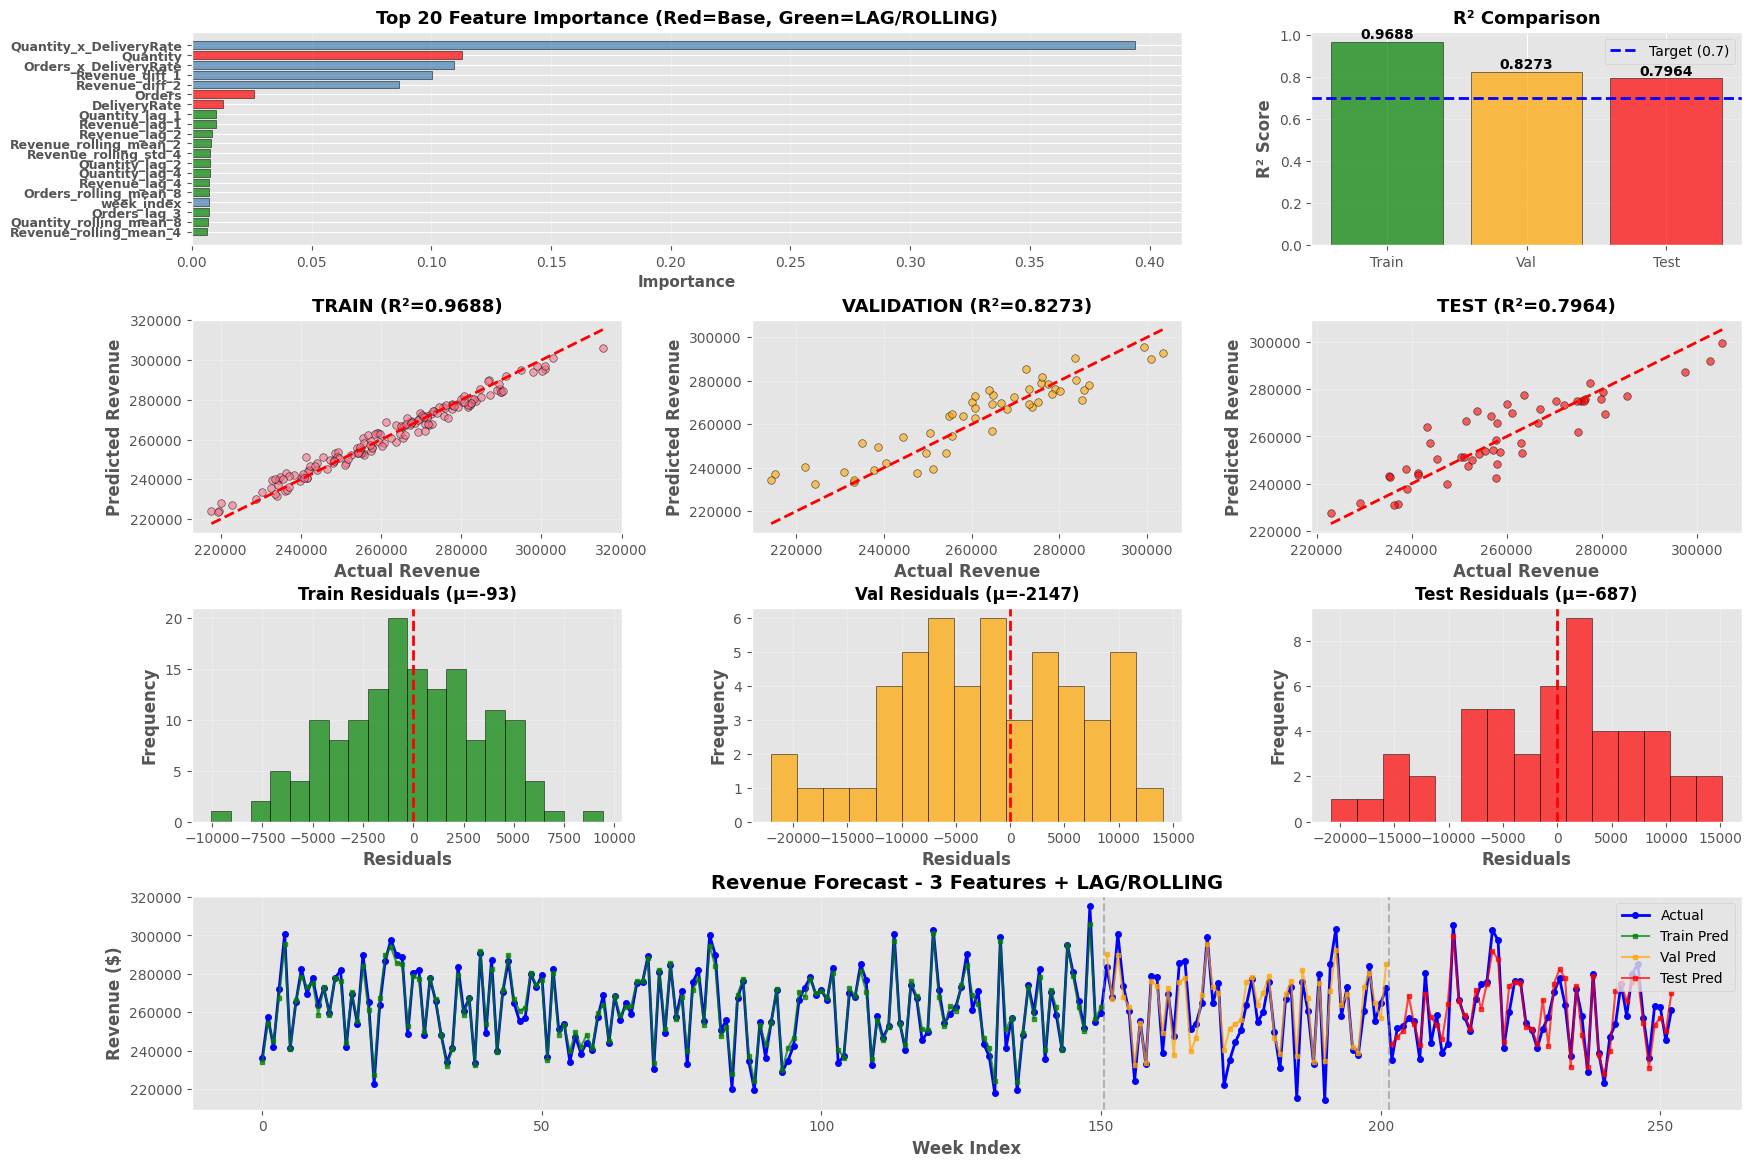


📋 FINAL SUMMARY - 3 FEATURES + LAG/ROLLING

🎯 MODEL PERFORMANCE:
   Metric          Train           Validation      Test           
   ------------------------------------------------------------
   R²              0.9688          0.8273          0.7964         
   MAE             $2,860          $7,275          $6,441         
   RMSE            $3,530          $8,850          $8,164         
   MAPE            1.10          % 2.86          % 2.49          %

📊 FEATURE SUMMARY:
   - Base features: 3 (Quantity, Orders, DeliveryRate)
   - Total features after engineering: 32
   - Top feature: Quantity_x_DeliveryRate (0.3939)

✅ GOAL CHECK:
   🎉 SUCCESS! Test R² = 0.7964 >= 0.7


In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
import warnings

warnings.filterwarnings("ignore")

print("=" * 80)
print("🌲 RANDOM FOREST - CHỈ 3 FEATURES + LAG/ROLLING")
print("=" * 80)

# =============================================================================
# 1️⃣ CHUẨN BỊ DỮ LIỆU - CHỈ LẤY 3 FEATURES GỐC
# =============================================================================
print("\n1️⃣ Chuẩn bị dữ liệu - Chỉ 3 features gốc")
print("-" * 80)

# Chỉ lấy 3 features cơ bản
selected_features = ["Quantity", "Orders", "DeliveryRate"]

# Kiểm tra features có tồn tại không
available_features = [f for f in selected_features if f in weekly_full.columns]
print(f"✅ Selected features: {available_features}")

# Tạo X_base chỉ với 3 features
X_base = weekly_full[available_features].copy()
y = weekly_full["Revenue"].copy()

print(f"✅ Base dataset:")
print(f"   - X shape: {X_base.shape}")
print(f"   - Features: {available_features}")

# =============================================================================
# 2️⃣ FEATURE ENGINEERING - TẠO LAG & ROLLING
# =============================================================================
print("\n2️⃣ Feature Engineering - Tạo LAG & ROLLING features")
print("-" * 80)

# LAG FEATURES
print("\n📊 Creating LAG features...")
for lag in [1, 2, 3, 4]:
    X_base[f"Revenue_lag_{lag}"] = y.shift(lag)
    X_base[f"Orders_lag_{lag}"] = X_base["Orders"].shift(lag)
    X_base[f"Quantity_lag_{lag}"] = X_base["Quantity"].shift(lag)

# ROLLING FEATURES
print("📊 Creating ROLLING features...")
for window in [2, 4, 8]:
    X_base[f"Revenue_rolling_mean_{window}"] = y.shift(1).rolling(window=window).mean()
    X_base[f"Revenue_rolling_std_{window}"] = y.shift(1).rolling(window=window).std()
    X_base[f"Orders_rolling_mean_{window}"] = (
        X_base["Orders"].shift(1).rolling(window=window).mean()
    )
    X_base[f"Quantity_rolling_mean_{window}"] = (
        X_base["Quantity"].shift(1).rolling(window=window).mean()
    )

# TREND FEATURES
print("📊 Creating TREND features...")
X_base["week_index"] = range(len(X_base))
X_base["Revenue_diff_1"] = y.diff(1)
X_base["Revenue_diff_2"] = y.diff(2)

# INTERACTION FEATURES
print("📊 Creating INTERACTION features...")
X_base["Orders_x_DeliveryRate"] = X_base["Orders"] * X_base["DeliveryRate"]
X_base["Quantity_x_DeliveryRate"] = X_base["Quantity"] * X_base["DeliveryRate"]

# Drop NaN
X_engineered = X_base.dropna()
y_engineered = y.loc[X_engineered.index]

print(f"\n✅ Feature Engineering completed:")
print(f"   - Original features: {len(available_features)}")
print(f"   - Total features after engineering: {X_engineered.shape[1]}")
print(f"   - Samples: {len(X_engineered)} (from {len(weekly_full)})")

print(f"\n📋 All features:")
for i, feat in enumerate(X_engineered.columns, 1):
    emoji = (
        "🔴"
        if feat in available_features
        else ("🟢" if "lag" in feat or "rolling" in feat else "🟡")
    )
    print(f"   {i:2d}. {emoji} {feat}")

# =============================================================================
# 3️⃣ TRAIN-VALIDATION-TEST SPLIT (60-20-20)
# =============================================================================
print("\n" + "=" * 80)
print("3️⃣ TRAIN-VALIDATION-TEST SPLIT (60-20-20)")
print("=" * 80)

n = len(X_engineered)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

X_train = X_engineered.iloc[:train_end]
y_train = y_engineered.iloc[:train_end]

X_val = X_engineered.iloc[train_end:val_end]
y_val = y_engineered.iloc[train_end:val_end]

X_test = X_engineered.iloc[val_end:]
y_test = y_engineered.iloc[val_end:]

print(f"\n✅ Split completed:")
print(f"   - TRAIN:      {len(X_train)} weeks ({len(X_train)/n*100:.1f}%)")
print(f"   - VALIDATION: {len(X_val)} weeks ({len(X_val)/n*100:.1f}%)")
print(f"   - TEST:       {len(X_test)} weeks ({len(X_test)/n*100:.1f}%)")

# =============================================================================
# 4️⃣ HYPERPARAMETER TUNING
# =============================================================================
print("\n" + "=" * 80)
print("4️⃣ HYPERPARAMETER TUNING (Grid Search)")
print("=" * 80)

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [15, 20, 25, 30],
    "min_samples_split": [2, 3, 5],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt", "log2", 0.5],
    "max_samples": [0.8, 0.9, 1.0],
}

print(f"🔍 Testing {np.prod([len(v) for v in param_grid.values()])} combinations...")

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1, bootstrap=True),
    param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
)

grid_search.fit(X_train, y_train)

print(f"\n✅ Best Parameters:")
for param, value in grid_search.best_params_.items():
    print(f"   - {param}: {value}")
print(f"\n📊 Best CV R² (on TRAIN): {grid_search.best_score_:.4f}")

# =============================================================================
# 5️⃣ ĐÁNH GIÁ MÔ HÌNH
# =============================================================================
print("\n" + "=" * 80)
print("5️⃣ MODEL EVALUATION ON ALL 3 SETS")
print("=" * 80)

rf_final = grid_search.best_estimator_

y_train_pred = rf_final.predict(X_train)
y_val_pred = rf_final.predict(X_val)
y_test_pred = rf_final.predict(X_test)


def evaluate_model(y_true, y_pred, dataset_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    print(f"\n📊 {dataset_name}:")
    print(f"   - R²:    {r2:.4f}")
    print(f"   - MAE:   ${mae:,.2f}")
    print(f"   - RMSE:  ${rmse:,.2f}")
    print(f"   - MAPE:  {mape:.2f}%")

    return {"R2": r2, "MAE": mae, "RMSE": rmse, "MAPE": mape}


train_metrics = evaluate_model(y_train, y_train_pred, "TRAIN SET")
val_metrics = evaluate_model(y_val, y_val_pred, "VALIDATION SET")
test_metrics = evaluate_model(y_test, y_test_pred, "TEST SET")

# =============================================================================
# 6️⃣ FEATURE IMPORTANCE
# =============================================================================
print("\n" + "=" * 80)
print("6️⃣ FEATURE IMPORTANCE")
print("=" * 80)

feature_importance = pd.DataFrame(
    {"Feature": X_engineered.columns, "Importance": rf_final.feature_importances_}
).sort_values("Importance", ascending=False)

print(f"\n📊 Top 15 Most Important Features:")
print(feature_importance.head(15).to_string(index=False))

# Phân loại features
base_features = available_features
lag_rolling_features = [
    f for f in feature_importance["Feature"] if "lag" in f or "rolling" in f
]

print(f"\n📋 Feature Type Summary:")
print(
    f"   - Base features (3):        {len([f for f in feature_importance.head(10)['Feature'] if f in base_features])}/10 in Top 10"
)
print(
    f"   - LAG/ROLLING features:     {len([f for f in feature_importance.head(10)['Feature'] if f in lag_rolling_features])}/10 in Top 10"
)

# =============================================================================
# 7️⃣ VISUALIZATION
# =============================================================================
print("\n" + "=" * 80)
print("7️⃣ CREATING VISUALIZATIONS")
print("=" * 80)

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. Feature Importance
ax1 = fig.add_subplot(gs[0, :2])
top20 = feature_importance.head(20)
colors = []
for f in top20["Feature"]:
    if f in base_features:
        colors.append("red")  # Base features
    elif "lag" in f or "rolling" in f:
        colors.append("green")  # LAG/ROLLING
    else:
        colors.append("steelblue")  # Other

ax1.barh(
    range(len(top20)), top20["Importance"], color=colors, alpha=0.7, edgecolor="black"
)
ax1.set_yticks(range(len(top20)))
ax1.set_yticklabels(top20["Feature"], fontsize=9, fontweight="bold")
ax1.set_xlabel("Importance", fontweight="bold", fontsize=11)
ax1.set_title(
    "Top 20 Feature Importance (Red=Base, Green=LAG/ROLLING)",
    fontweight="bold",
    fontsize=13,
)
ax1.grid(True, alpha=0.3, axis="x")
ax1.invert_yaxis()

# 2. R² Comparison
ax2 = fig.add_subplot(gs[0, 2])
datasets = ["Train", "Val", "Test"]
r2_scores_list = [train_metrics["R2"], val_metrics["R2"], test_metrics["R2"]]
colors_r2 = ["green", "orange", "red"]
bars = ax2.bar(datasets, r2_scores_list, color=colors_r2, alpha=0.7, edgecolor="black")
ax2.axhline(y=0.7, color="blue", linestyle="--", linewidth=2, label="Target (0.7)")
ax2.set_ylabel("R² Score", fontweight="bold")
ax2.set_title("R² Comparison", fontweight="bold", fontsize=13)
ax2.legend()
ax2.grid(True, alpha=0.3, axis="y")
for bar, score in zip(bars, r2_scores_list):
    height = bar.get_height()
    ax2.text(
        bar.get_x() + bar.get_width() / 2.0,
        height,
        f"{score:.4f}",
        ha="center",
        va="bottom",
        fontweight="bold",
    )

# 3-5. Actual vs Predicted
ax3 = fig.add_subplot(gs[1, 0])
ax3.scatter(y_train, y_train_pred, alpha=0.6, edgecolors="k", s=30)
ax3.plot(
    [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", linewidth=2
)
ax3.set_xlabel("Actual Revenue", fontweight="bold")
ax3.set_ylabel("Predicted Revenue", fontweight="bold")
ax3.set_title(f'TRAIN (R²={train_metrics["R2"]:.4f})', fontweight="bold", fontsize=13)
ax3.grid(True, alpha=0.3)

ax4 = fig.add_subplot(gs[1, 1])
ax4.scatter(y_val, y_val_pred, alpha=0.6, edgecolors="k", s=30, color="orange")
ax4.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], "r--", linewidth=2)
ax4.set_xlabel("Actual Revenue", fontweight="bold")
ax4.set_ylabel("Predicted Revenue", fontweight="bold")
ax4.set_title(
    f'VALIDATION (R²={val_metrics["R2"]:.4f})', fontweight="bold", fontsize=13
)
ax4.grid(True, alpha=0.3)

ax5 = fig.add_subplot(gs[1, 2])
ax5.scatter(y_test, y_test_pred, alpha=0.6, edgecolors="k", s=30, color="red")
ax5.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", linewidth=2)
ax5.set_xlabel("Actual Revenue", fontweight="bold")
ax5.set_ylabel("Predicted Revenue", fontweight="bold")
ax5.set_title(f'TEST (R²={test_metrics["R2"]:.4f})', fontweight="bold", fontsize=13)
ax5.grid(True, alpha=0.3)

# 6-8. Residuals
ax6 = fig.add_subplot(gs[2, 0])
residuals_train = y_train - y_train_pred
ax6.hist(residuals_train, bins=20, edgecolor="black", alpha=0.7, color="green")
ax6.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax6.set_xlabel("Residuals", fontweight="bold")
ax6.set_ylabel("Frequency", fontweight="bold")
ax6.set_title(
    f"Train Residuals (μ={residuals_train.mean():.0f})", fontweight="bold", fontsize=12
)
ax6.grid(True, alpha=0.3)

ax7 = fig.add_subplot(gs[2, 1])
residuals_val = y_val - y_val_pred
ax7.hist(residuals_val, bins=15, edgecolor="black", alpha=0.7, color="orange")
ax7.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax7.set_xlabel("Residuals", fontweight="bold")
ax7.set_ylabel("Frequency", fontweight="bold")
ax7.set_title(
    f"Val Residuals (μ={residuals_val.mean():.0f})", fontweight="bold", fontsize=12
)
ax7.grid(True, alpha=0.3)

ax8 = fig.add_subplot(gs[2, 2])
residuals_test = y_test - y_test_pred
ax8.hist(residuals_test, bins=15, edgecolor="black", alpha=0.7, color="red")
ax8.axvline(x=0, color="red", linestyle="--", linewidth=2)
ax8.set_xlabel("Residuals", fontweight="bold")
ax8.set_ylabel("Frequency", fontweight="bold")
ax8.set_title(
    f"Test Residuals (μ={residuals_test.mean():.0f})", fontweight="bold", fontsize=12
)
ax8.grid(True, alpha=0.3)

# 9. Time Series
ax9 = fig.add_subplot(gs[3, :])
all_weeks = range(len(y_engineered))
ax9.plot(
    all_weeks,
    y_engineered.values,
    marker="o",
    linewidth=2,
    label="Actual",
    color="blue",
    markersize=4,
)

train_weeks = range(len(y_train))
val_weeks = range(len(y_train), len(y_train) + len(y_val))
test_weeks = range(len(y_train) + len(y_val), len(y_engineered))

ax9.plot(
    train_weeks,
    y_train_pred,
    marker="s",
    linewidth=1.5,
    label="Train Pred",
    color="green",
    alpha=0.7,
    markersize=3,
)
ax9.plot(
    val_weeks,
    y_val_pred,
    marker="s",
    linewidth=1.5,
    label="Val Pred",
    color="orange",
    alpha=0.7,
    markersize=3,
)
ax9.plot(
    test_weeks,
    y_test_pred,
    marker="s",
    linewidth=1.5,
    label="Test Pred",
    color="red",
    alpha=0.7,
    markersize=3,
)

ax9.axvline(
    x=len(y_train) - 0.5, color="gray", linestyle="--", linewidth=1.5, alpha=0.5
)
ax9.axvline(
    x=len(y_train) + len(y_val) - 0.5,
    color="gray",
    linestyle="--",
    linewidth=1.5,
    alpha=0.5,
)

ax9.set_xlabel("Week Index", fontweight="bold", fontsize=12)
ax9.set_ylabel("Revenue ($)", fontweight="bold", fontsize=12)
ax9.set_title(
    "Revenue Forecast - 3 Features + LAG/ROLLING", fontweight="bold", fontsize=14
)
ax9.legend(fontsize=10, loc="best")
ax9.grid(True, alpha=0.3)

plt.show()

# =============================================================================
# 8️⃣ FINAL SUMMARY
# =============================================================================
print("\n" + "=" * 80)
print("📋 FINAL SUMMARY - 3 FEATURES + LAG/ROLLING")
print("=" * 80)

print(f"\n🎯 MODEL PERFORMANCE:")
print(f"   {'Metric':<15} {'Train':<15} {'Validation':<15} {'Test':<15}")
print(f"   {'-'*60}")
print(
    f"   {'R²':<15} {train_metrics['R2']:<15.4f} {val_metrics['R2']:<15.4f} {test_metrics['R2']:<15.4f}"
)
print(
    f"   {'MAE':<15} ${train_metrics['MAE']:<14,.0f} ${val_metrics['MAE']:<14,.0f} ${test_metrics['MAE']:<14,.0f}"
)
print(
    f"   {'RMSE':<15} ${train_metrics['RMSE']:<14,.0f} ${val_metrics['RMSE']:<14,.0f} ${test_metrics['RMSE']:<14,.0f}"
)
print(
    f"   {'MAPE':<15} {train_metrics['MAPE']:<14.2f}% {val_metrics['MAPE']:<14.2f}% {test_metrics['MAPE']:<14.2f}%"
)

print(f"\n📊 FEATURE SUMMARY:")
print(f"   - Base features: {len(base_features)} (Quantity, Orders, DeliveryRate)")
print(f"   - Total features after engineering: {X_engineered.shape[1]}")
print(
    f"   - Top feature: {feature_importance.iloc[0]['Feature']} ({feature_importance.iloc[0]['Importance']:.4f})"
)

print(f"\n✅ GOAL CHECK:")
if test_metrics["R2"] >= 0.7:
    print(f"   🎉 SUCCESS! Test R² = {test_metrics['R2']:.4f} >= 0.7")
else:
    print(f"   ⚠️ Test R² = {test_metrics['R2']:.4f} < 0.7")
    print(f"   📈 Gap to target: {0.7 - test_metrics['R2']:.4f}")

print("=" * 80)